# Imports

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from pandas_profiling import ProfileReport 

%matplotlib inline
sns.set()

from math import ceil

# Reading the Data

In [2]:
df = pd.read_csv('donors.csv', header=0, index_col=[0], low_memory=False, 
                 dtype={'TCODE':'str','HPHONE_D':'str','RFA_2F':'str','WEALTH1':'str','WEALTH2':'str','INCOME':'str'})
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A


In [3]:
#df = pd.read_csv('donors.csv', header=0, index_col=[0,'CONTROLN'], low_memory=False, 
#                 dtype={'TCODE':'str','HPHONE_D':'str','RFA_2F':'str','WEALTH1':'str','WEALTH2':'str','INCOME':'str'})
#df.head()

# Initial Analysis

In [4]:
# Checking for duplicates:
df.duplicated().sum()

0

In [5]:
# check df data types:
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE       object
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 475, dtype: object

In [6]:
# replace "" by nans:
df.replace("", np.nan, inplace=True)

In [7]:
# sorted count of missing values:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)

RDATE_5     95403
RAMNT_5     95403
RDATE_3     95170
RAMNT_3     95170
RDATE_4     95131
            ...  
MSA           132
ADI           132
DMA           132
GEOCODE2      132
FISTDATE        2
Length: 92, dtype: int64

In [8]:
# checking descriptive statistics:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NUMCHLD,12386.0,1.527773,0.806861,1.000000,1.000000,1.000000,2.000000,7.0
HIT,95412.0,3.321438,9.306899,0.000000,0.000000,0.000000,3.000000,241.0
MBCRAFT,42558.0,0.152075,0.470023,0.000000,0.000000,0.000000,0.000000,6.0
MBGARDEN,42558.0,0.059166,0.262078,0.000000,0.000000,0.000000,0.000000,4.0
MBBOOKS,42558.0,1.116382,1.669967,0.000000,0.000000,0.000000,2.000000,9.0
...,...,...,...,...,...,...,...,...
MAXRAMNT,95412.0,19.999790,25.067746,5.000000,14.000000,17.000000,23.000000,5000.0
LASTGIFT,95412.0,17.313127,13.956630,0.000000,10.000000,15.000000,20.000000,1000.0
TIMELAG,85439.0,8.093739,8.213242,0.000000,4.000000,6.000000,11.000000,1088.0
AVGGIFT,95412.0,13.347786,10.769997,1.285714,8.384615,11.636364,15.477955,1000.0


### Feature Engineering

In [9]:
df["ODATEDW"] = df["ODATEDW"].apply(lambda x: x[:7])

In [10]:
df['DOB'] = df['DOB'].apply(lambda x: int(str(x)[:4]) if (str(x)!='nan') else None)
df['DOB'] = 2020 - df['DOB']
df.rename(columns={'DOB':'Age'},inplace=True)

## Missing Values

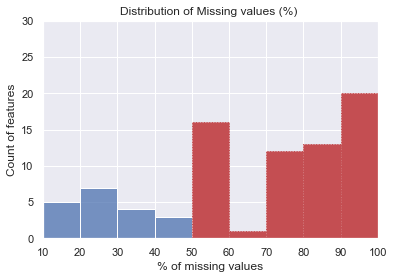

In [11]:
# Plotting the distribution of missing values(greater than 10%)
ax = sns.histplot(df.isnull().mean()*100, bins='auto')
ax.set_title('Distribution of Missing values (%) ')
ax.set(xlabel='% of missing values', ylabel='Count of features',xlim=(10,100),ylim=(0,30))
# Colloring red the bars that represent the count of features with % of missing values >= 50% :
for i in range(5,10):
    ax.patches[i].set_color('r')
    ax.patches[i].set_linestyle(':')
plt.show(ax)

### Removing the features that have missing values

We are removing all the columns that have more than 50% of Missing Values

### Nota: Ver as ADATES

In [12]:
cols = df.columns[df.isnull().mean() > 0.5]

display(pd.DataFrame(df[cols].isnull().mean()*100, columns=['% Missing Values']).sort_values(by='% Missing Values',ascending=False))

df = df.drop(cols, axis=1)

,% Missing Values
RDATE_5,99.990567
RAMNT_5,99.990567
RAMNT_3,99.746363
RDATE_3,99.746363
RDATE_4,99.705488
...,...
PUBPHOTO,55.395548
PUBCULIN,55.395548
MBCRAFT,55.395548
PUBHLTH,55.395548


#### Metric and Non-Metric Variables:

In [13]:
def update_metric_feat(df):
    metric_features = df.select_dtypes(include=np.number).columns
    non_metric_features = df.select_dtypes(exclude=np.number).columns
    return metric_features.tolist(),non_metric_features.tolist()

metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

## Outliers

#### Box Plots:

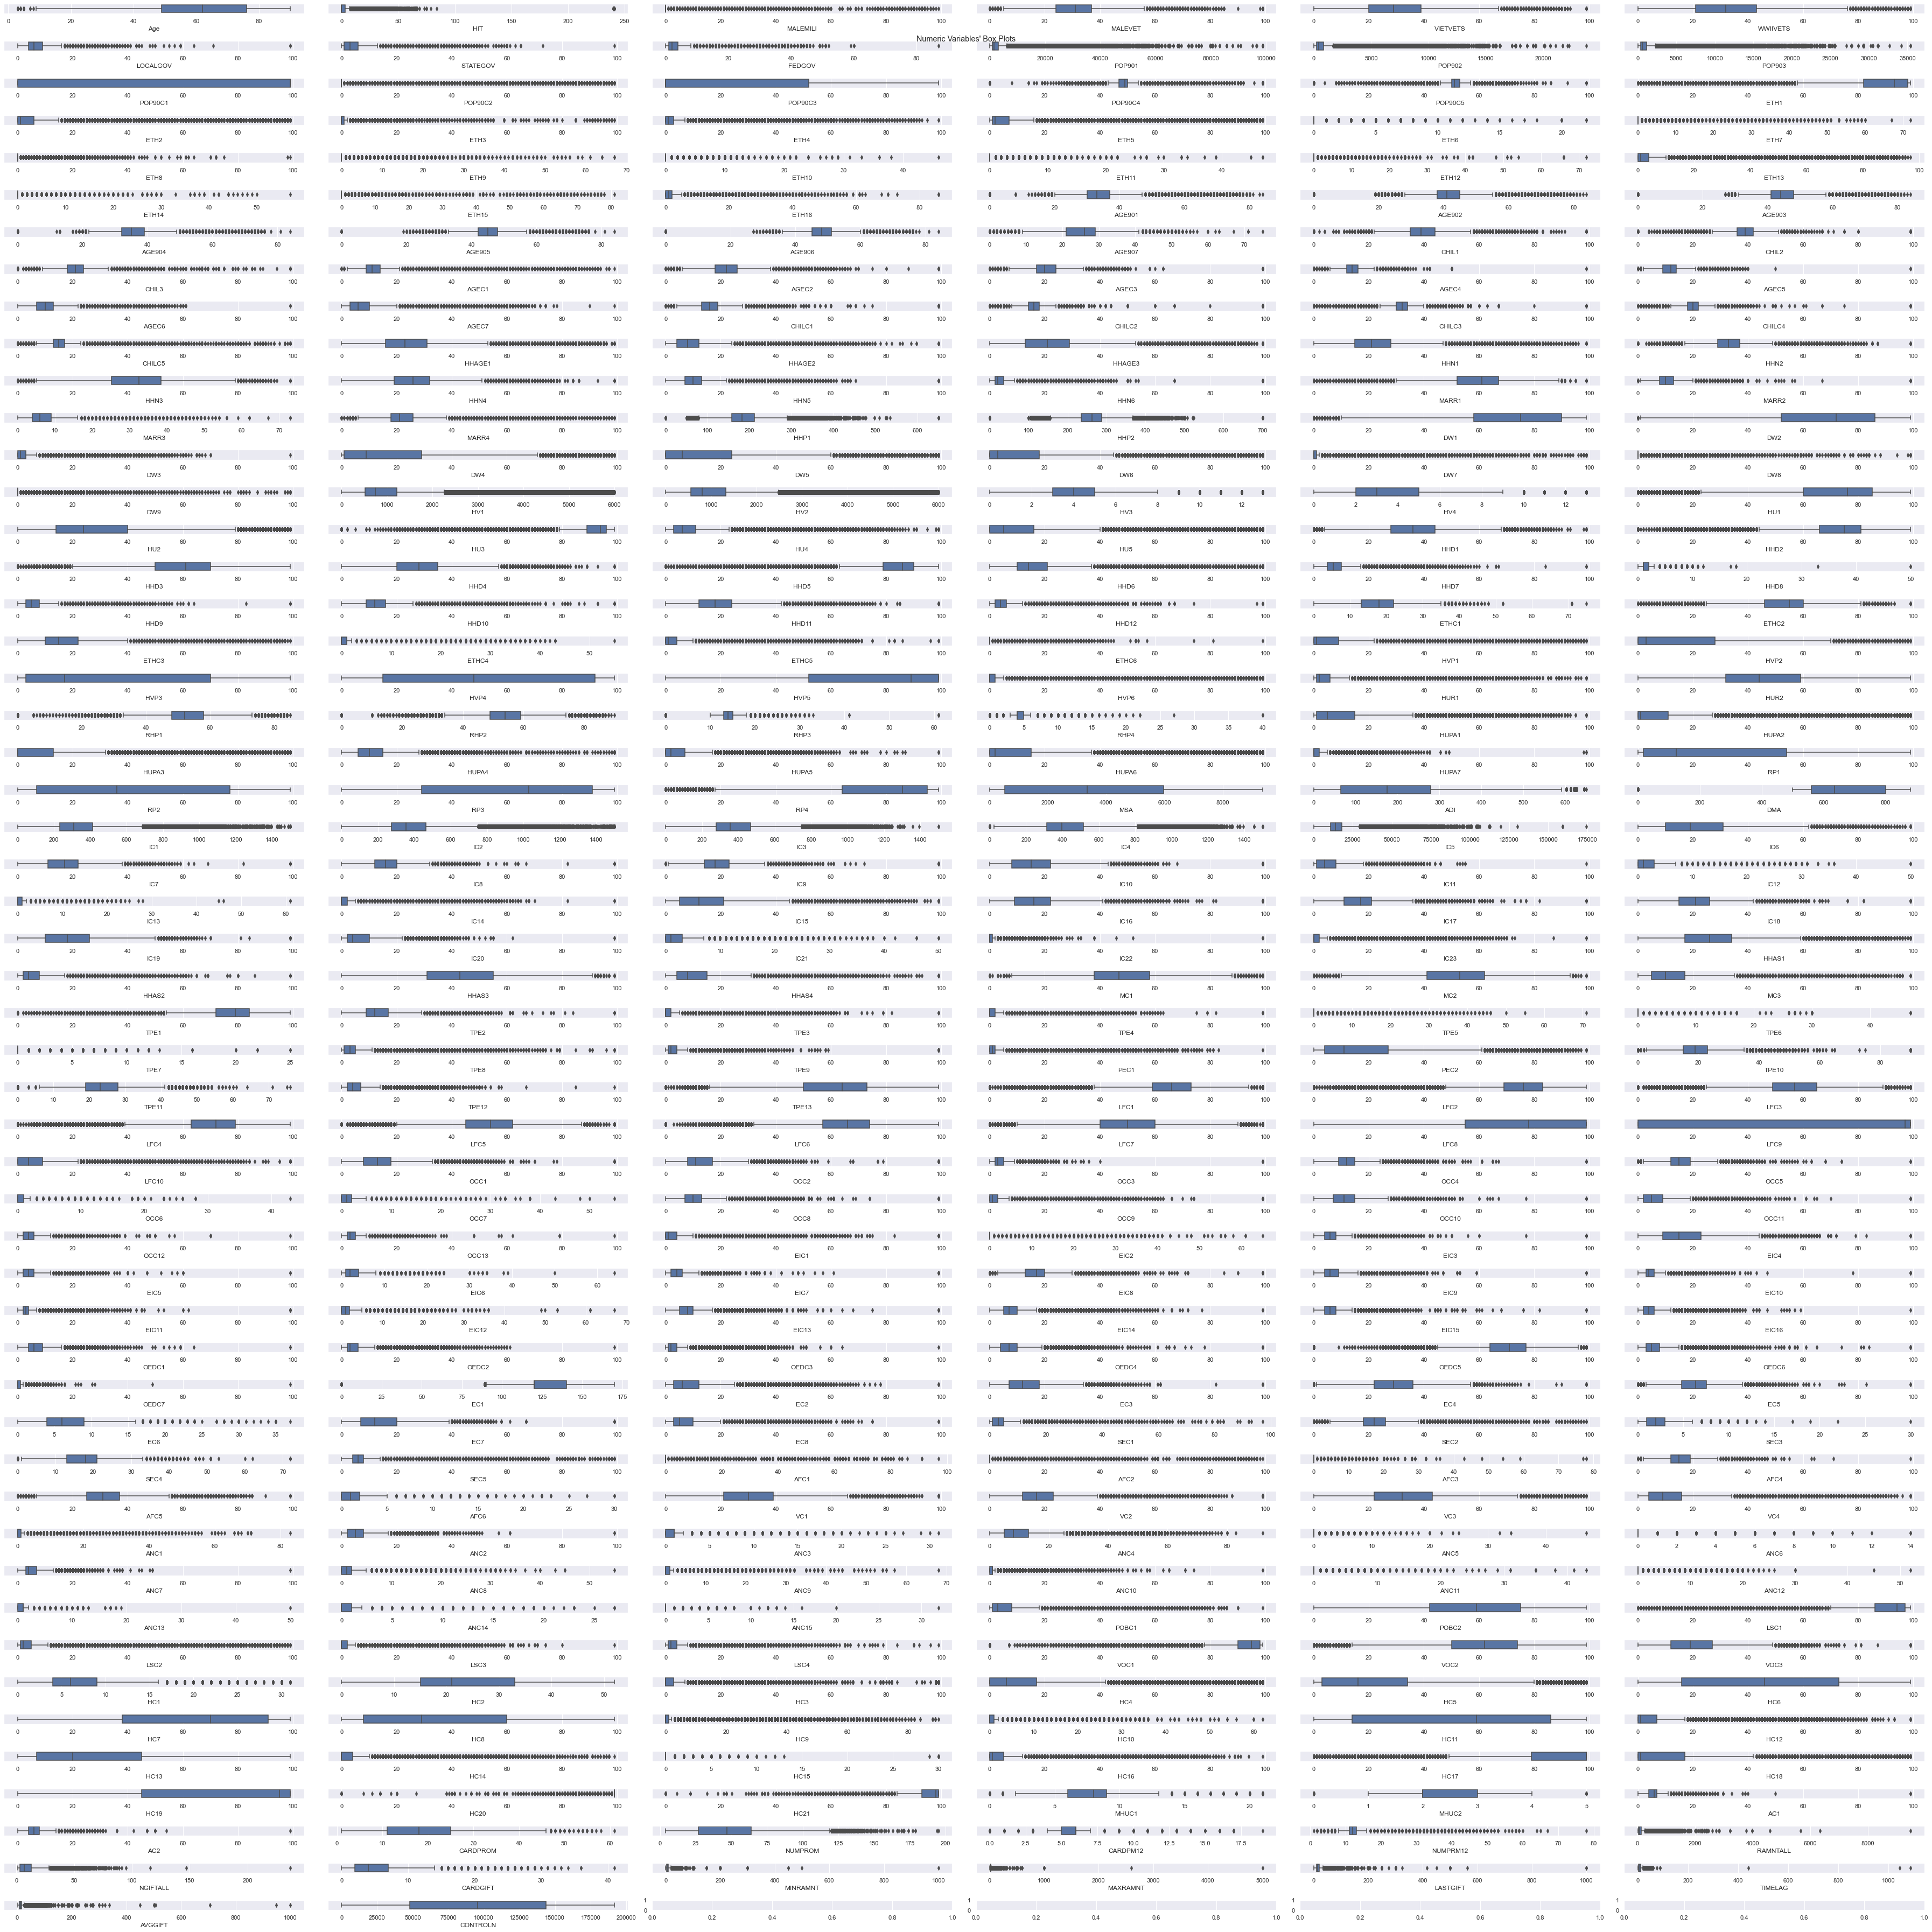

In [14]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(52, ceil(len(metric_features) / 52), figsize=(50, 50), squeeze=True)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
#     ax.set_title(feat, y=-0.21)

# Adjusting my subplots:
fig.tight_layout()

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)

plt.show()

# Treatment of Outliers - Metric features

### IQR Method 

In [15]:
df_IQR = df.copy()

q25 = df_IQR.quantile(.25)
q75 = df_IQR.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df_IQR[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
filters2 = filters2.apply(lambda x: 1 if x==True else(0))
#df_IQR = df_IQR.merge(filters2.rename("IQR"), left_index=True, right_index=True)

### Z-score
It is only convenient to use in a low dimensional feature space, in a small to
medium sized dataset.

In [16]:
df_standard = df.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
df_standard[metric_features] = scaled_feat
df_standard[metric_features]

,Age,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN
0,0.077122,-0.356881,-0.206977,0.745798,0.284659,-0.826571,0.719013,-0.501028,-0.508013,-0.394185,...,0.251554,1.142781,2.501429,1.975369,-0.333970,-0.319128,-0.523992,-0.498435,-0.520509,-0.004760
1,-0.816445,1.362283,-0.206977,-1.346527,1.675602,-1.221851,-0.191801,-0.501028,-0.508013,0.061833,...,0.031484,-0.484816,-0.771780,-0.896527,0.235235,0.199469,0.550771,1.206140,0.215310,0.954282
2,NaN,-0.141985,-0.206977,-0.910626,-0.046518,0.020458,-0.191801,0.669340,-0.508013,0.652098,...,0.251554,0.822321,2.033828,1.975369,-0.675493,-0.159560,-0.882247,0.475608,-0.544692,-1.459730
3,0.613263,-0.141985,-0.206977,-0.649086,-1.040049,-0.092480,-0.874911,-0.891151,-0.026682,-0.455475,...,0.251554,0.038039,0.747925,0.428964,-0.675493,-0.359021,-0.523992,0.110342,-0.606808,1.388782
4,1.089832,6.089983,-0.009563,-0.213185,-1.371225,1.149829,4.362269,-0.305967,-0.267347,-0.128131,...,2.672324,1.260845,3.202831,0.649879,-0.561652,-0.199452,-0.165738,0.719119,-0.601946,-1.603822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,NaN,-0.356881,2.556819,0.484257,1.145719,-1.221851,0.035903,0.669340,2.379972,4.200476,...,-0.188586,-0.670345,-1.005580,-1.117442,1.942849,0.199469,0.550771,NaN,1.081920,1.606058
95408,-0.697303,-0.249433,-0.206977,0.048356,0.880777,-0.770102,-0.647208,-0.696089,-0.748678,-0.348566,...,-1.068866,-0.712511,-1.005580,-1.117442,1.373644,0.000008,0.192517,NaN,0.617665,0.487079
95409,0.017551,-0.356881,-0.206977,-1.084987,1.079483,-0.713634,0.035903,3.595261,-0.748678,-0.470798,...,0.911764,-0.392051,-0.304178,-0.233782,-0.561652,-0.398913,-0.523992,-0.620190,-0.470019,1.697820
95410,-0.101591,-0.356881,-0.206977,-0.213185,0.350894,-0.713634,0.491310,-0.696089,-0.508013,-0.262899,...,3.992743,3.318532,3.670433,2.859029,-0.333970,0.039900,0.049215,-0.498435,-0.111555,-1.647577


In [17]:
#Here we want that all the columns have a z-score lower than 3 or greater than -3 for not being an oulier

df_Zscore = df_standard[metric_features][((df_standard[metric_features] < 3).all(axis=1)) & ((df_standard[metric_features] > -3).all(axis=1))]
df_Zscore

,Age,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN
0,0.077122,-0.356881,-0.206977,0.745798,0.284659,-0.826571,0.719013,-0.501028,-0.508013,-0.394185,...,0.251554,1.142781,2.501429,1.975369,-0.333970,-0.319128,-0.523992,-0.498435,-0.520509,-0.004760
9,0.374978,-0.356881,-0.206977,-0.213185,1.410660,-1.052445,-0.419504,-0.501028,-0.267347,-0.112983,...,-0.848796,-0.645046,-0.771780,-0.896527,-0.561652,-0.199452,-0.165738,-0.133169,-0.372746,-0.829696
20,0.136693,0.717596,0.187851,-0.474725,0.682071,-0.318354,0.946717,-0.110905,-0.508013,-0.095571,...,-0.188586,-0.366752,0.631024,1.091709,-0.675493,-0.518589,-0.882247,0.475608,-0.861761,-0.232167
23,0.911119,-0.356881,-0.206977,-1.084987,-0.046518,-1.108914,-1.102615,-0.696089,-0.508013,-0.220414,...,-0.628726,0.029606,0.397224,0.649879,-0.561652,0.000008,-0.595643,-0.741945,-0.467978,-0.065591
29,-1.293015,-0.356881,-0.206977,0.222716,0.615836,-0.318354,-0.191801,-0.110905,-0.267347,-0.184546,...,-0.188586,-0.400485,-0.304178,-0.454697,-0.333970,-0.398913,-0.595643,-0.133169,-0.483283,0.037838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95391,-0.578161,-0.356881,0.582679,0.571437,1.410660,-0.713634,-0.647208,0.474279,2.379972,-0.175491,...,-1.288936,1.058449,-0.304178,-0.675612,-0.561652,1.276556,2.342044,-0.620190,1.811464,-1.300734
95393,0.613263,1.362283,0.780093,0.832978,0.085953,0.020458,0.263606,1.644647,-0.026682,-0.162432,...,0.691694,0.029606,0.163423,0.428964,-0.333970,-0.199452,-0.237389,-0.254924,-0.327727,-1.424259
95394,0.791976,-0.034538,-0.206977,0.658618,0.682071,0.189863,0.035903,-0.501028,-0.267347,-0.266556,...,-0.408656,0.016956,0.046523,0.870794,-0.333970,-0.199452,-0.165738,-0.376679,-0.250492,-1.097349
95398,1.625973,-0.356881,-0.009563,0.135536,-0.576401,-0.374822,0.491310,-0.696089,-0.748678,-0.154597,...,0.691694,0.333199,0.046523,-0.233782,-0.333970,0.199469,0.192517,0.840874,0.097699,-0.306546


In [18]:
print('Percentage of data kept after removing outliers:', np.round(df_Zscore.shape[0]/ df_standard.shape[0], 4)) #REMOVE A LOT

Percentage of data kept after removing outliers: 0.1579


In [19]:
df_Zscore["Zscore"] = pd.Series(0, index = df_Zscore.index) #Creating a column saying the 0 are the inliners, so the 1 is the outliers
df_Zscore

,Age,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,Zscore
0,0.077122,-0.356881,-0.206977,0.745798,0.284659,-0.826571,0.719013,-0.501028,-0.508013,-0.394185,...,1.142781,2.501429,1.975369,-0.333970,-0.319128,-0.523992,-0.498435,-0.520509,-0.004760,0
9,0.374978,-0.356881,-0.206977,-0.213185,1.410660,-1.052445,-0.419504,-0.501028,-0.267347,-0.112983,...,-0.645046,-0.771780,-0.896527,-0.561652,-0.199452,-0.165738,-0.133169,-0.372746,-0.829696,0
20,0.136693,0.717596,0.187851,-0.474725,0.682071,-0.318354,0.946717,-0.110905,-0.508013,-0.095571,...,-0.366752,0.631024,1.091709,-0.675493,-0.518589,-0.882247,0.475608,-0.861761,-0.232167,0
23,0.911119,-0.356881,-0.206977,-1.084987,-0.046518,-1.108914,-1.102615,-0.696089,-0.508013,-0.220414,...,0.029606,0.397224,0.649879,-0.561652,0.000008,-0.595643,-0.741945,-0.467978,-0.065591,0
29,-1.293015,-0.356881,-0.206977,0.222716,0.615836,-0.318354,-0.191801,-0.110905,-0.267347,-0.184546,...,-0.400485,-0.304178,-0.454697,-0.333970,-0.398913,-0.595643,-0.133169,-0.483283,0.037838,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95391,-0.578161,-0.356881,0.582679,0.571437,1.410660,-0.713634,-0.647208,0.474279,2.379972,-0.175491,...,1.058449,-0.304178,-0.675612,-0.561652,1.276556,2.342044,-0.620190,1.811464,-1.300734,0
95393,0.613263,1.362283,0.780093,0.832978,0.085953,0.020458,0.263606,1.644647,-0.026682,-0.162432,...,0.029606,0.163423,0.428964,-0.333970,-0.199452,-0.237389,-0.254924,-0.327727,-1.424259,0
95394,0.791976,-0.034538,-0.206977,0.658618,0.682071,0.189863,0.035903,-0.501028,-0.267347,-0.266556,...,0.016956,0.046523,0.870794,-0.333970,-0.199452,-0.165738,-0.376679,-0.250492,-1.097349,0
95398,1.625973,-0.356881,-0.009563,0.135536,-0.576401,-0.374822,0.491310,-0.696089,-0.748678,-0.154597,...,0.333199,0.046523,-0.233782,-0.333970,0.199469,0.192517,0.840874,0.097699,-0.306546,0


In [20]:
df_standard["Zscore"] = df_Zscore["Zscore"]
df_standard["Zscore"] = df_standard["Zscore"].apply(lambda x: 0 if x==0 else 1)

In [21]:
df_standard

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,Zscore
0,2009-01,GRI,0,IL,61081,,,0.077122,0,,...,-0.004760,0,L,4,E,X,X,X,C,0
1,2014-01,BOA,1,CA,91326,,,-0.816445,0,,...,0.954282,0,L,2,G,X,X,X,A,1
2,2010-01,AMH,1,NC,27017,,,NaN,0,,...,-1.459730,1,L,4,E,X,X,X,C,1
3,2007-01,BRY,0,CA,95953,,,0.613263,0,,...,1.388782,1,L,4,E,X,X,X,C,1
4,2006-01,,0,FL,33176,,,1.089832,0,X,...,-1.603822,1,L,2,F,X,X,X,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01,ASE,1,AK,99504,,,NaN,0,,...,1.606058,0,L,1,G,X,X,X,C,1
95408,2016-01,DCD,1,TX,77379,,,-0.697303,0,,...,0.487079,1,L,1,F,X,X,X,A,1
95409,2015-01,MBC,1,MI,48910,,,0.017551,0,,...,1.697820,1,L,3,E,X,X,X,B,1
95410,2006-01,PRV,0,CA,91320,,,-0.101591,0,X,...,-1.647577,1,L,4,F,X,X,X,A,1


 ###### ----------------------------------------------------------------------------------------------------------

In [ ]:
#Pretendo retirar as linhas cujos valores sejam superiores a threshold 3

#indexes = []
#for metric in metric_features:
#    index = df_standard[metric_features].loc[(df_standard[metric_features][metric]<-3) | (df_standard[metric_features][metric]>=3)].index
#    if len(index)!=0:
#        indexes.append(index)
#    else: continue
#indexes

list_ = []
for i in indexes:
    for t in i:
        list_.append(t)
list_

In [ ]:
#Find the duplicates --- but we should remove the ones who repeat the most, I think

seen = set()
uniq = [x for x in list_ if x not in seen and not seen.add(x)]
uniq

In [ ]:
len(uniq)

#### Precisaria de uma regra, já que não se removeu tanto, aquando é /10

In [ ]:
import collections
print([item for item, count in collections.Counter(list_).items() if count > (413/7)]) #59 em 413---- hmmm

In [ ]:
import collections
indexes_ = [item for item, count in collections.Counter(list_).items() if count > (413/10)] #41,3 em 413----- hmm
len(indexes_)

In [ ]:
print('Percentage of data kept after removing outliers:', np.round((df_standard.shape[0]-len(indexes_)) / df_standard.shape[0], 4))

In [ ]:
#Só para compreender

In [ ]:
df_standard[metric_features].iloc[18817][df_standard[metric_features].iloc[18817] <= -3]

In [ ]:
df_standard[metric_features].iloc[18817][df_standard[metric_features].iloc[18817] >= 3]

In [ ]:
#É que não  posso retirar pela média. porque os valores dão completamente diferentes

In [ ]:
df_standard[metric_features].iloc[18817].mean()

In [ ]:
df_standard[metric_features].iloc[3922].mean()

### Median Absolute Deviation method

In [22]:
from scipy import stats

In [32]:
df_mda = df[metric_features].copy()
#MAD = stats.median_abs_deviation(df_mda, axis=1, nan_policy="omit")
MAD = stats.median_abs_deviation(df_mda, axis=1)
MAD

array([10. , 10. ,  nan, ...,  9.5, 11. , 10. ])

In [33]:
MAD = pd.Series(MAD)
MAD

0        10.0
1        10.0
2         NaN
3        12.0
4        11.0
         ... 
95407     NaN
95408     NaN
95409     9.5
95410    11.0
95411    10.0
Length: 95412, dtype: float64

In [34]:
MAD[(MAD<3) & (MAD>-3)] #Supostamente, se utilizar o NAN_policy omit - 933 observações não são outliers hahaha embarcamos mesmo assim nesta aventura?

100      0.0
262      0.0
522      0.0
640      0.0
801      2.5
        ... 
94026    0.0
94635    0.0
94697    0.0
95197    0.0
95213    0.0
Length: 397, dtype: float64

In [39]:
import package_outlier as po
df_mda = df.copy()
modified_zscore, mad, outliers = po.modified_zscore_and_anomaly_detection(df_mda[metric_features], threshold=3)
print(modified_zscore)
print(mad)
print(outliers)

C:\Users\catsd\anaconda3\lib\site-packages\package_outlier\__init__.py:38: RuntimeWarning: invalid value encountered in greater
  mask = mod_zscore > threshold


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
Empty DataFrame
Columns: [Age, HIT, MALEMILI, MALEVET, VIETVETS, WWIIVETS, LOCALGOV, STATEGOV, FEDGOV, POP901, POP902, POP903, POP90C1, POP90C2, POP90C3, POP90C4, POP90C5, ETH1, ETH2, ETH3, ETH4, ETH5, ETH6, ETH7, ETH8, ETH9, ETH10, ETH11, ETH12, ETH13, ETH14, ETH15, ETH16, AGE901, AGE902, AGE903, AGE904, AGE905, AGE906, AGE907, CHIL1, CHIL2, CHIL3, AGEC1, AGEC2, AGEC3, AGEC4, AGEC5, AGEC6, AGEC7, CHILC1, CHILC2, CHILC3, CHILC4, CHILC5, HHAGE1, HHAGE2, HHAGE3, HHN1, HHN2, HHN3, HHN4, HHN5, HHN6, MARR1, MARR2, MARR3, MARR4, HHP1, HHP2, DW1, DW2, DW3, DW4, DW5, DW6, DW7, DW8, DW9, HV1, HV2, HV3, HV4, HU1, HU2, HU3, HU4, HU5, HHD1, HHD2, HHD3, HHD4, HHD5, HHD6, HHD7, HHD8, HHD9, HHD10, HHD11, HHD12, ...]
Index: []

[0 rows x 308 columns]


In [ ]:
def MAD(dataframe, variable):
    columns = dataframe.columns
    med = np.median(dataframe, axis = 0)
    mad = np.abs(stats.median_absolute_deviation(dataframe))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable:
            index == item
    for i, v in enumerate(dataframe.loc[:,variable]):
        t = (v-med[item])/mad[item]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

outlier_mad = MAD(df, "HIT")

In [ ]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

## Fill missing values (Data imputation)

Filling the Categorical Variables with the mode and the Numeric Variables with the Median

In [40]:
for column in df[non_metric_features]:
    df[column] = df[column].fillna(df[column].mode()[0])

for column in df[metric_features]:
    df[column] = df[column].fillna(df[column].median())

In [41]:
df.isnull().sum()

ODATEDW     0
OSOURCE     0
TCODE       0
STATE       0
ZIP         0
           ..
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
GEOCODE2    0
Length: 413, dtype: int64

### Local Outlier Factor

In [42]:
df_LOF = df.copy()

LOF = LocalOutlierFactor()
predict = LOF.fit_predict(df_LOF[metric_features].values) # Label is 1 for an inlier and -1 for an outlier according to the LOF score and the contamination parameter.
df_LOF_array = pd.DataFrame(predict, columns = ["LOF"])
df_LOF = df_LOF.merge(df_LOF_array, left_index=True, right_index=True)
df_LOF

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,LOF
0,2009-01,GRI,0,IL,61081,,,63.0,0,,...,95515,0,L,4,E,X,X,X,C,1
1,2014-01,BOA,1,CA,91326,,,48.0,0,,...,148535,0,L,2,G,X,X,X,A,1
2,2010-01,AMH,1,NC,27017,,,62.0,0,,...,15078,1,L,4,E,X,X,X,C,1
3,2007-01,BRY,0,CA,95953,,,72.0,0,,...,172556,1,L,4,E,X,X,X,C,1
4,2006-01,,0,FL,33176,,,80.0,0,X,...,7112,1,L,2,F,X,X,X,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01,ASE,1,AK,99504,,,62.0,0,,...,184568,0,L,1,G,X,X,X,C,1
95408,2016-01,DCD,1,TX,77379,,,50.0,0,,...,122706,1,L,1,F,X,X,X,A,1
95409,2015-01,MBC,1,MI,48910,,,62.0,0,,...,189641,1,L,3,E,X,X,X,B,1
95410,2006-01,PRV,0,CA,91320,,,60.0,0,X,...,4693,1,L,4,F,X,X,X,A,1


In [43]:
print('Percentage of data kept after removing outliers:', np.round(df_LOF.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 1.0


In [44]:
df_test = df_LOF.merge(filters2.rename("IQR"), left_index=True, right_index=True)
df_test = df_test.merge(df_standard["Zscore"], left_index =True, right_index =True)
df_test

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,LOF,IQR,Zscore
0,2009-01,GRI,0,IL,61081,,,63.0,0,,...,L,4,E,X,X,X,C,1,0,0
1,2014-01,BOA,1,CA,91326,,,48.0,0,,...,L,2,G,X,X,X,A,1,0,1
2,2010-01,AMH,1,NC,27017,,,62.0,0,,...,L,4,E,X,X,X,C,1,0,1
3,2007-01,BRY,0,CA,95953,,,72.0,0,,...,L,4,E,X,X,X,C,1,0,1
4,2006-01,,0,FL,33176,,,80.0,0,X,...,L,2,F,X,X,X,A,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01,ASE,1,AK,99504,,,62.0,0,,...,L,1,G,X,X,X,C,1,0,1
95408,2016-01,DCD,1,TX,77379,,,50.0,0,,...,L,1,F,X,X,X,A,1,0,1
95409,2015-01,MBC,1,MI,48910,,,62.0,0,,...,L,3,E,X,X,X,B,1,0,1
95410,2006-01,PRV,0,CA,91320,,,60.0,0,X,...,L,4,F,X,X,X,A,1,0,1


In [45]:
df_test.query("LOF == -1 & IQR == 1 & Zscore == 1") #This just give me 0 outliers to remove ---> Strange as f*ck

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,LOF,IQR,Zscore


In [46]:
df_test.query("IQR == 1") #This conjugated with the others methods don't add information

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,LOF,IQR,Zscore
403,2010-01,AML,0,AL,35811,,,20.0,0,,...,L,4,D,X,X,X,B,1,1,0
457,2009-01,IMP,0,IN,47396,,,52.0,0,,...,L,3,G,X,X,X,C,1,1,0
6919,2015-01,ARG,1,IL,61611,,,86.0,0,,...,L,3,E,X,X,X,B,1,1,0
8050,2012-01,SYN,0,IN,46219-,,,74.0,0,,...,L,1,F,X,X,X,B,1,1,0
9427,2010-01,MBC,2,GA,30165,,,59.0,0,,...,L,2,G,X,X,X,C,1,1,0
12133,2009-01,DNA,0,MO,64503,,,82.0,0,,...,L,2,F,X,X,X,C,1,1,0
13411,2006-01,GUR,1,KY,40503,,,42.0,0,,...,L,1,E,X,X,X,B,1,1,0
17406,2010-01,MBC,1,IL,62521,,,52.0,0,,...,L,4,F,X,X,X,C,1,1,0
24997,2010-01,IMP,0,IL,62554,,,50.0,0,,...,L,1,G,X,X,X,C,1,1,0
26835,2006-01,USS,0,TX,79106,,,82.0,0,,...,L,4,D,X,X,X,C,1,1,0


In [47]:
df_test.query("LOF == -1 & Zscore == 1") #This just give me 2049 outliers to remove

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,LOF,IQR,Zscore
78,2010-01,BHG,0,CA,92625,,,72.0,0,,...,L,2,F,X,X,X,A,-1,0,1
82,2015-01,NSH,0,TX,75082,,,56.0,0,,...,L,3,E,X,X,X,A,-1,0,1
105,2015-01,VIK,0,CA,90024,,,62.0,0,,...,L,2,G,X,X,X,A,-1,0,1
168,2016-01,HOS,0,GA,30905,,,62.0,0,,...,L,1,F,X,X,X,B,-1,0,1
209,2013-01,DNB,1,CA,93550,,,48.0,0,,...,L,1,F,X,X,X,A,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95193,2011-01,L01,1,CA,90071,,,62.0,0,,...,L,2,F,X,X,X,A,-1,0,1
95197,2008-01,AHN,0,MI,49501,,,40.0,0,,...,L,1,G,X,X,X,B,-1,0,1
95262,2016-01,ADD,0,CO,80246,,,62.0,0,,...,L,1,G,X,X,X,B,-1,0,1
95335,2016-01,MCO,1,MT,59802,,,53.0,0,,...,L,1,F,X,X,X,C,-1,0,1


In [48]:
print('Percentage of data kept after removing outliers:', np.round((df_test.shape[0] - 2049)/ df_test.shape[0], 4))

Percentage of data kept after removing outliers: 0.9785


In [49]:
df.drop(index = df_test.query("LOF == -1 & Zscore == 1").index, inplace = True)

In [50]:
df

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,Age,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01,GRI,0,IL,61081,,,63.0,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01,BOA,1,CA,91326,,,48.0,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01,AMH,1,NC,27017,,,62.0,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01,BRY,0,CA,95953,,,72.0,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01,,0,FL,33176,,,80.0,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95406,2010-01,LHJ,0,FL,32776-,,,52.0,0,,...,3.375000,35088,0,L,4,D,X,X,X,C
95407,2016-01,ASE,1,AK,99504,,,62.0,0,,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,2016-01,DCD,1,TX,77379,,,50.0,0,,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,2015-01,MBC,1,MI,48910,,,62.0,0,,...,8.285714,189641,1,L,3,E,X,X,X,B


# Metric Features

## Low Variance

Removing variables with low Variance

Done on a scaled data using MinMax Scaler

If the variance is too low, it means that it does not change much and hence it can be ignored


#### -> Function that plots Histograms of a set of variables:

In [51]:
def histograms(df,features, bins='auto',figsize=(15, 8)):
    # Put this Variables' Histograms in one figure
    sns.set()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(ceil(len(features) / 4),4, figsize=figsize)

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], bins=bins)
        ax.set_title(feat, y=-0.17)

    # Layout
    # Add a centered title to the figure:
    title = "Variables' Histograms"
    plt.suptitle(title)
    plt.show()

In [52]:
# Scalling our data:
scaler = MinMaxScaler()
# transform data:
scaled = scaler.fit_transform(df[metric_features])
scaled = pd.DataFrame(scaled,columns = metric_features)

The following are redundant variables because of their low variance:
 ['ETH8', 'ETH10', 'ETH11', 'ETH12', 'ETH14', 'HHD8', 'ETHC6', 'RHP4', 'IC22', 'TPE6', 'TPE7', 'OCC3', 'OCC6', 'OEDC7', 'AFC3', 'ANC1', 'ANC5', 'ANC11', 'ANC13', 'ANC15', 'HC15', 'AC1', 'RAMNTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TIMELAG', 'AVGGIFT']


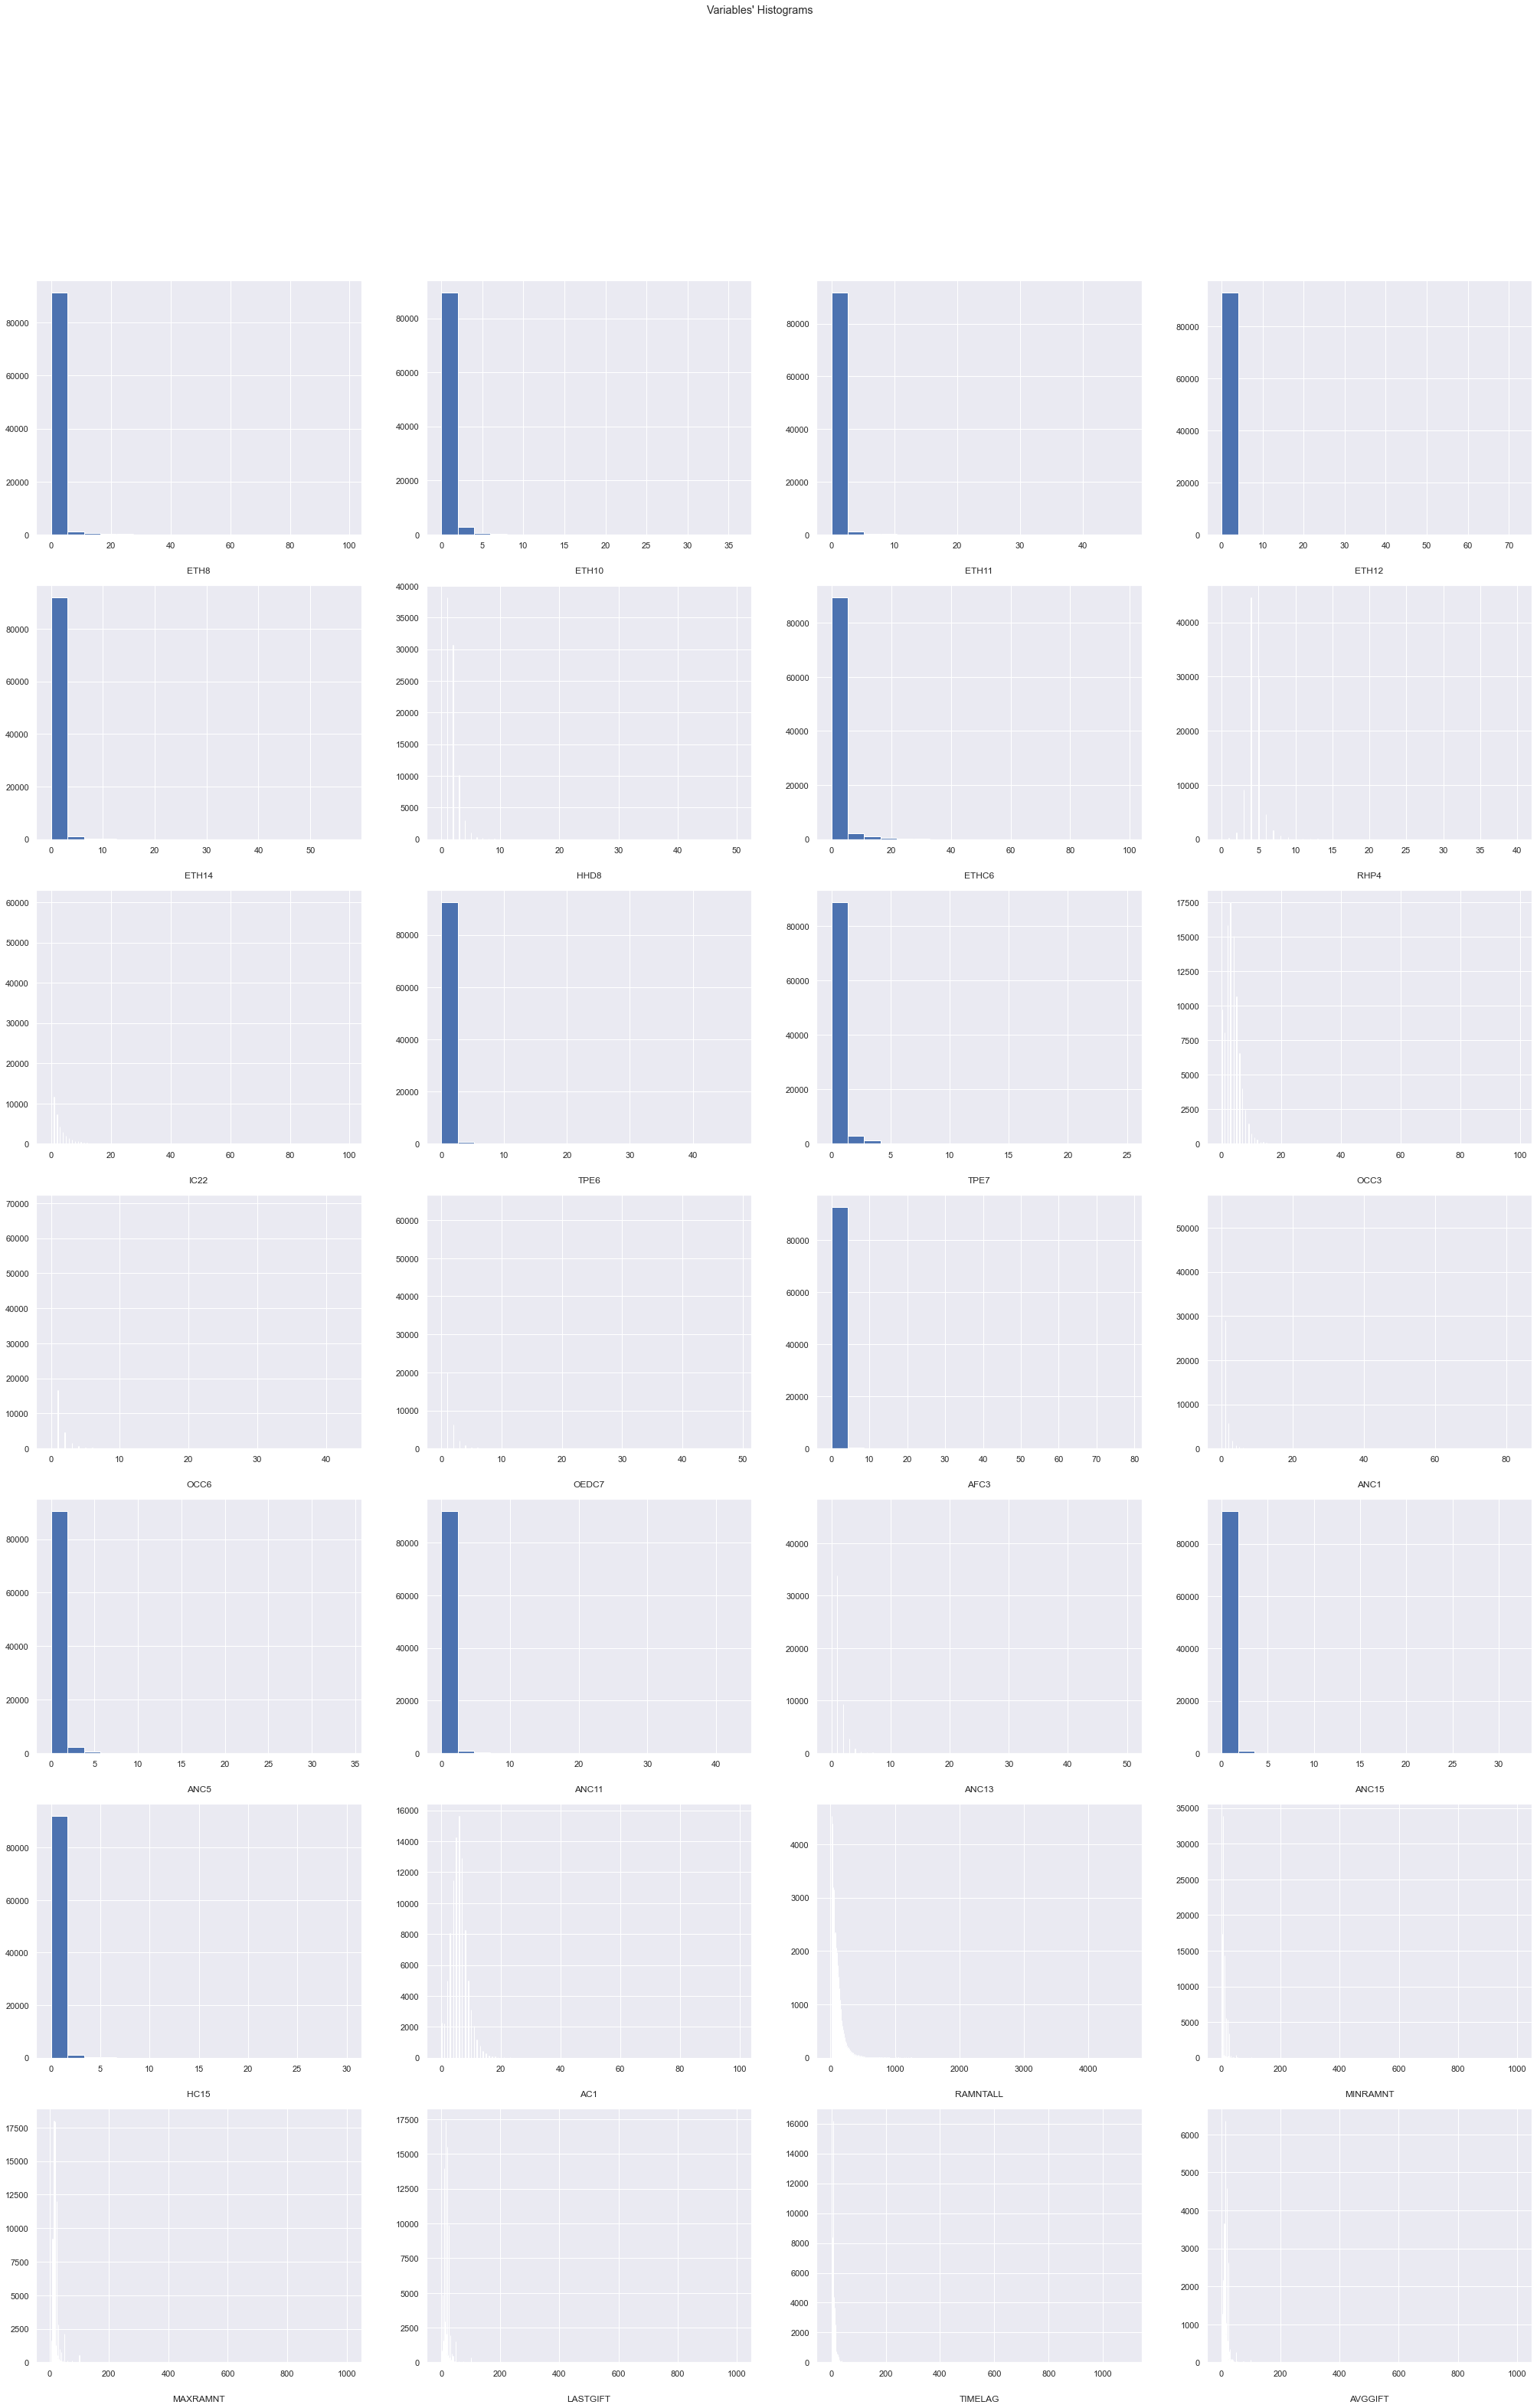

In [53]:
low_variance_features = []
for feature in metric_features:
    if (scaled[feature].var())<0.0009:
        low_variance_features.append(feature)

print('The following are redundant variables because of their low variance:\n',low_variance_features)

#Plotting an histogram of those variables:
histograms(df,low_variance_features, bins='auto',figsize=(35, 50))

# Dropping (note: I wont drop the boolean variable HPHONE_D because it only takes 0 and 1 values so it will easily have a std 
# value above my threshold, but I won´t consider it has being redundant):
df.drop(columns=low_variance_features, inplace=True)

#updating metric features list:
metric_features = update_metric_feat(df)[0]



In [54]:
display(pd.DataFrame(scaled[metric_features].var(), columns=['Variance']).sort_values(by='Variance'))

,Variance
HUPA7,0.000925
ETH7,0.000931
EIC7,0.000942
ETH6,0.000949
ANC12,0.000984
...,...
HVP3,0.136241
HVP4,0.137170
POP90C3,0.164139
LFC9,0.203732


## Correlation
Remove the features that have high correlation values (threshold of 80%) -> To avoid multicolinearity

For each pair of correlated features, our method identifies one of the features for removal (because we only need to remove one of them)

Make visualization with the high correlations (ex:heatmap that shows all the features that have at least one correlation above the threshold)

Make list of correlated features that will be removed, or show the highly correlated pairs of features in a dataframe

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features

#### -> Function that plots an heatmap of the correlation matrix passed as input

In [55]:
def corr_heatmap(corr):    
    # Prepare figure
    fig = plt.figure(figsize=(50, 30))
    # Build annotation matrix (values above |0.8| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= 0.8
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))
    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot_kws={"size": 10})
    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)
    plt.show()

#### -> Handling with highly correlated Features:

The features to be removed because of their high correlation are:
 ['POP902', 'POP903', 'ETH13', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGEC6', 'CHILC1', 'CHILC3', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR3', 'HHP1', 'HHP2', 'DW2', 'DW5', 'DW6', 'HV2', 'HV4', 'HU2', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD9', 'HHD11', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'RHP1', 'RHP2', 'RHP3', 'HUPA2', 'HUPA5', 'HUPA6', 'RP1', 'RP2', 'RP3', 'RP4', 'IC2', 'IC3', 'IC4', 'IC5', 'IC11', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC23', 'HHAS1', 'HHAS4', 'MC2', 'TPE4', 'TPE11', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'EIC1', 'OEDC1', 'OEDC2', 'OEDC3', 'EC8', 'SEC4', 'AFC2', 'AFC5', 'VC3', 'LSC2', 'LSC3', 'VOC2', 'VOC3', 'HC5', 'HC6', 'HC7', 'HC8', 'HC18', 'HC21', 'NUMPROM', 'CARDGIFT']


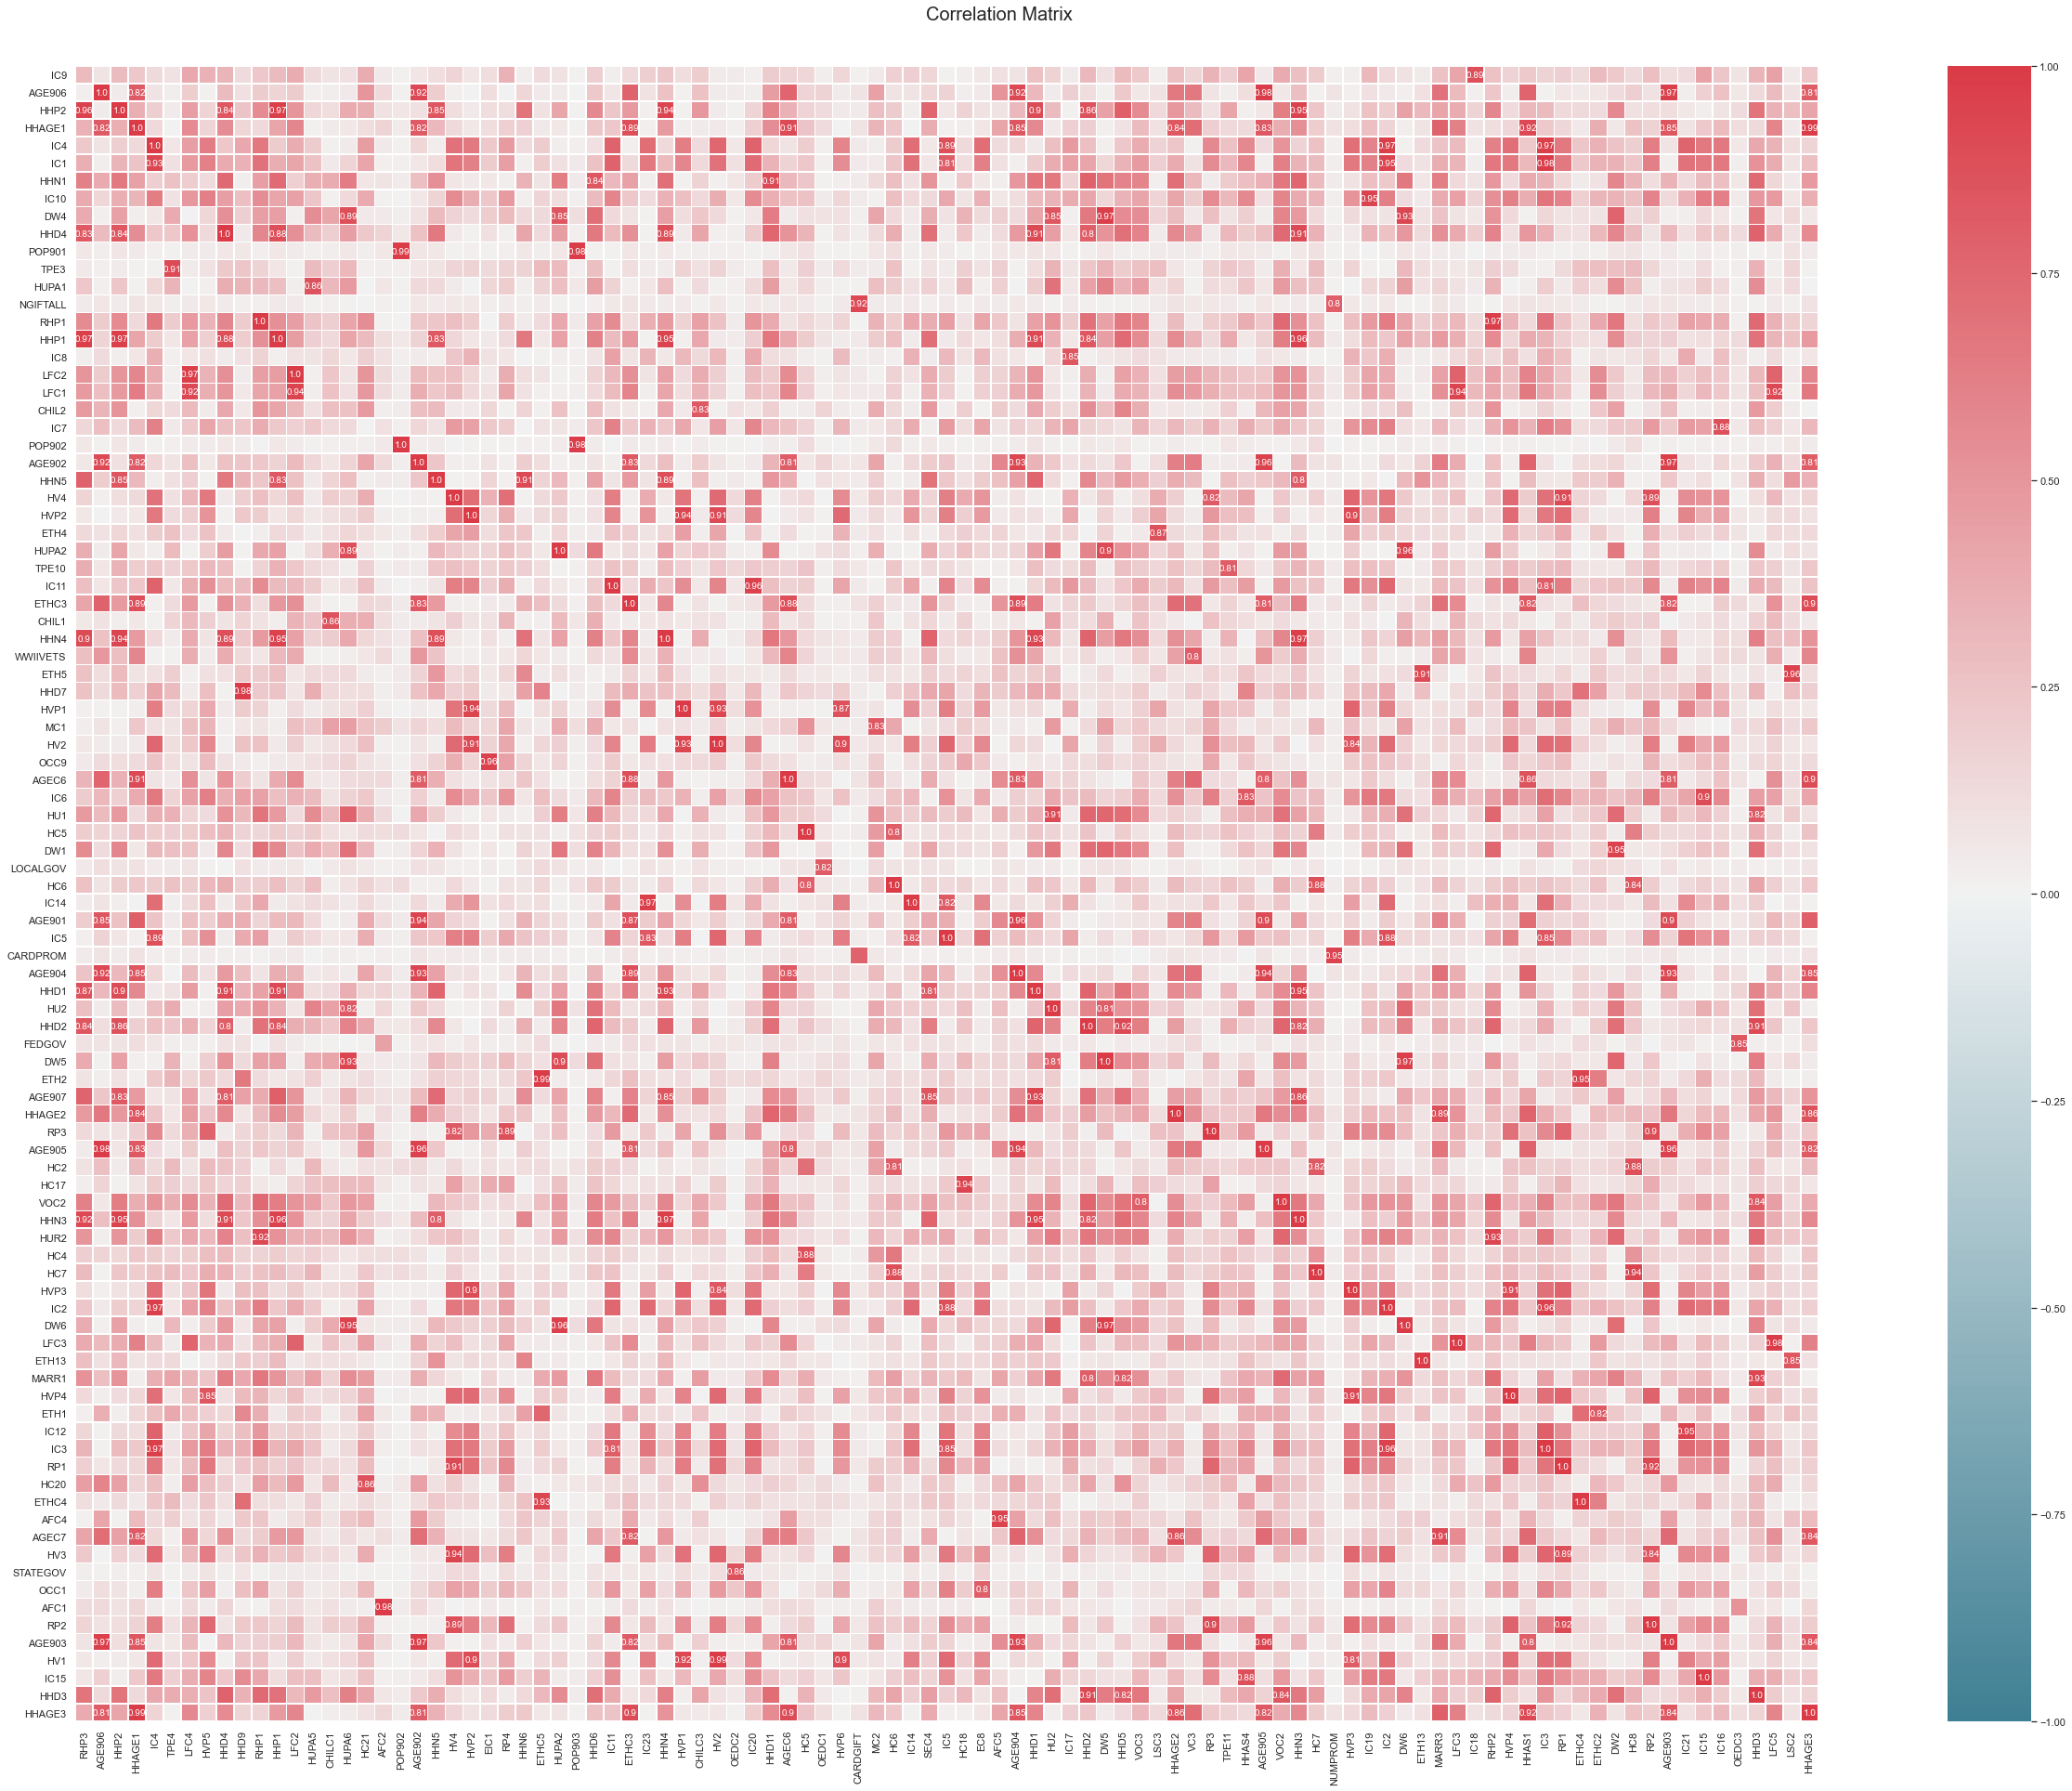

In [56]:
# Creating correlation matrix with the absolute values of the corr:
corr = df.corr().abs()

# Selecting upper triangle of the correlation matrix:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Finding the index of the feature's columns with correlation greater than 0.80 (>=very strong correlation)
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

print('The features to be removed because of their high correlation are:\n',to_drop)

# Saving the pairs of correlated features so I can plot an heatmap of their correlations:

# I´ll save both the dropped feature and the one that was correlated with it:
records = pd.DataFrame(columns = ['dropped_feat', 'corr_feat'])
for column in to_drop:
    corr_features = list(upper.index[upper[column].abs() > 0.8])
    drop_features = [column for _ in range(len(corr_features))]
    # Record the information (need a temp df for now)
    aux_df = pd.DataFrame.from_dict({'dropped_feat': drop_features,'corr_feat': corr_features})

    # Add to dataframe
    records = records.append(aux_df, ignore_index = True)


corr_matrix_plot = corr.loc[list(set(records['corr_feat'])),list(set(records['dropped_feat']))]
title = "Correlations Above Threshold"
# * the features on the x axis are the ones that are going to be removed


# Plotting an heatmap:
corr_heatmap(np.round(corr_matrix_plot,decimals=2))


# Dropping the highly correlated features 
df.drop(columns = to_drop, inplace=True)

# updating metric features list:
metric_features = update_metric_feat(df)[0]

#### Some explanations

[Handle with variables of central tendency measures]

Once there are variables that provide the same information but in different measures, we decide to keep the variables that refer to the median because it's less sensitive to outliers and remove the others ones in these specific cases.

One example of the situation described above is the variable HHP1 (Median Person Per Household) and HHP2 (Average Person Per Household).


[Handle with redundant variables]

Since there are variables that have repeated information, that is, variables that englobe other variables, let's take into consideration, for example, HHN3 (Percent 3 or More Person Households) and HHN4 (Percent 4 or More Person Households). We can soon conclude that HHN4 is mentioned in HHN3, once 'more than 3' englobe the percent of 4 and so on.

In these particular cases, we decide to keep the variables that provide the same meaning as the others of the same kind, without losing information, and discard the ones that are already indirectly specified in the ones that we chose to keep.

#### -> PCA

In [94]:
df_pca = df.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_pca[metric_features]) #Necessário estarem normalizadas
df_pca[metric_features] = scaled_feat
df_pca[metric_features]

,Age,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,HC19,HC20,MHUC1,MHUC2,AC2,CARDPROM,CARDPM12,NUMPRM12,NGIFTALL,CONTROLN
0,0.083353,-0.358223,-0.212087,0.744578,0.282390,-0.831924,0.719112,-0.503842,-0.511357,-0.396320,...,-0.895416,0.147088,-0.609765,-0.392920,0.312830,0.994623,0.531946,0.248574,2.506456,0.000428
1,-0.946773,1.356052,-0.212087,-1.361305,1.678113,-1.228633,-0.195917,-0.503842,-0.511357,0.065761,...,0.762506,0.147088,3.407499,1.948873,-0.309935,-0.752662,0.531946,0.029367,-0.776021,0.957302
2,0.014678,-0.143938,-0.212087,-0.922579,-0.049925,0.018166,-0.195917,0.674894,-0.511357,0.663872,...,-1.541725,-0.067949,0.251077,-0.392920,-0.309935,0.878138,0.531946,0.248574,2.037530,-1.451252
3,0.701428,-0.143938,-0.212087,-0.659344,-1.046870,-0.095179,-0.882189,-0.896754,-0.024531,-0.458425,...,-1.401223,-0.498024,2.259709,-0.392920,0.001447,0.994623,0.531946,0.248574,0.747986,1.390819
4,1.250829,6.070309,-0.004003,-0.220618,-1.379186,1.151620,4.379229,-0.307386,-0.267944,-0.126729,...,-1.429324,0.147088,-0.609765,-0.392920,1.558360,2.858395,3.803621,2.659843,3.209844,-1.595018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95406,-0.672073,0.713199,0.204082,1.183304,-0.249314,0.754911,4.150472,0.871350,-0.511357,-0.247763,...,-2.019432,0.147088,-0.609765,-1.563817,0.624212,0.528680,-0.285973,-0.189839,1.685837,-1.090123
95407,0.014678,-0.358223,2.701096,0.481343,1.146409,-1.228633,0.032840,0.674894,2.409598,4.259420,...,0.734406,0.147088,2.259709,1.948873,-0.932700,-1.451577,-0.285973,-0.189839,-1.010484,1.607605
95408,-0.809423,-0.251081,-0.212087,0.042617,0.880557,-0.775252,-0.653432,-0.700298,-0.754770,-0.350094,...,-0.136706,0.147088,2.833604,3.119770,-1.244082,-1.684548,-1.921811,-1.066664,-1.010484,0.491155
95409,0.014678,-0.358223,-0.212087,-1.098069,1.079946,-0.718579,0.032840,3.621735,-0.754770,-0.473951,...,0.762506,0.147088,-0.896713,-0.392920,1.558360,-0.519691,1.349865,0.906193,-0.307096,1.699159


In [95]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])

In [96]:
df_pca_feat = pd.DataFrame(pca_feat)
df_pca_feat.round(2).head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,1.22,-4.29,0.30,0.16,-2.58,1.04,-1.44,-0.64,-0.90,1.90,...,-0.17,-0.04,0.03,-0.05,-0.02,0.02,0.02,-0.01,0.0,0.01
1,-11.40,2.06,-1.17,5.82,-2.39,-5.20,4.28,-1.62,0.17,-1.52,...,0.07,0.09,-0.05,-0.01,-0.00,0.04,0.01,0.01,-0.0,-0.00
2,4.46,-4.91,-0.71,-0.09,0.07,-0.17,0.35,-3.15,2.35,1.30,...,0.03,0.07,0.03,0.00,0.02,-0.00,0.00,-0.00,0.0,0.00
3,3.59,0.92,-0.93,2.73,-0.10,-4.31,5.00,-1.18,-3.29,-0.20,...,0.07,-0.06,-0.33,-0.02,0.09,0.02,0.05,0.00,-0.0,0.03
4,4.18,0.09,0.42,-0.55,-5.52,-0.08,0.68,5.16,4.05,1.29,...,0.01,-0.00,-0.09,-0.01,0.05,-0.01,-0.04,0.01,0.0,-0.01


In [97]:
## Getting the Loadings aka Weights aka eigenvectors

# However, I also found this: Loadings = Eigenvectors*sqrt(Eigenvalues)

df_pca_loadings = pd.DataFrame(pca.components_)
df_pca_loadings.head(10)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.009450,-0.014475,-0.001760,-0.026550,-0.032209,0.008925,0.007099,0.015903,0.002606,0.003460,...,-0.070221,-0.074503,-0.151347,-0.115386,-0.003883,0.007251,-0.000941,-0.002941,0.013225,-0.029494
1,0.001690,0.003231,0.020308,-0.074138,-0.019167,-0.013882,-0.012816,-0.003611,0.009183,0.014955,...,0.151935,-0.029324,0.023459,-0.018261,-0.072998,-0.016898,-0.001287,0.002135,-0.013848,0.048424
2,0.048164,0.010241,-0.041969,0.090164,-0.134519,0.159862,0.001685,-0.004271,-0.043978,-0.034513,...,-0.012031,-0.115555,-0.003456,-0.003526,0.127841,0.022744,0.006947,0.013783,0.018316,-0.017199
3,-0.036930,-0.014027,-0.000549,-0.097550,0.049688,-0.104883,-0.010405,-0.008876,0.001634,-0.009146,...,-0.074348,-0.261878,0.014440,-0.024080,-0.111326,-0.020873,-0.005329,-0.009870,-0.023620,0.032772
4,-0.024130,-0.024766,0.095632,0.029995,0.073017,-0.076383,-0.059163,-0.000869,0.064936,0.036684,...,-0.118189,-0.071384,0.007123,-0.043371,-0.071618,-0.025051,-0.008890,-0.006775,-0.017768,0.004418
5,-0.002174,0.023592,0.061076,-0.010085,0.046984,-0.058293,0.010338,0.130409,0.041129,-0.031697,...,0.054259,-0.046868,-0.107108,-0.025237,-0.106574,0.027269,0.006672,0.008826,0.025425,-0.063098
6,0.000898,-0.015820,0.031410,-0.043142,0.030948,-0.017209,0.076759,0.143233,0.055156,0.024684,...,-0.086266,0.047146,0.101218,0.024808,-0.003294,-0.009389,-0.008376,-0.011047,-0.016816,0.131597
7,0.023661,0.022813,0.168862,0.180830,0.046689,0.033724,0.145587,0.089050,0.239997,-0.015595,...,0.111304,-0.004971,-0.076626,-0.069021,0.083499,-0.017542,-0.017494,-0.023729,-0.016742,0.095061
8,-0.024896,-0.010350,0.004778,-0.029452,0.018408,-0.036272,-0.025303,0.084650,0.011353,0.042924,...,-0.061208,0.017453,0.023935,0.069587,-0.011090,-0.034881,-0.013041,0.005398,-0.034336,-0.223894
9,-0.003478,0.001614,0.108989,0.011397,-0.006037,-0.022602,-0.002378,-0.003004,0.098994,0.009482,...,-0.067378,-0.028287,-0.092207,-0.061009,0.001474,0.012982,0.011999,0.010378,0.015905,-0.025832


In [98]:
pca.explained_variance_ratio_.round(2)[:10]

array([0.11, 0.09, 0.06, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02])

There are three rules to choose the appropriate number of dimensions:

Pearson Criteria - Retain every component that has a eigenvalue higher or greater than 1 - This is only applied to standardized data --> This case 42/43 PC

Kaiser Criteria - Retain every component until we retain 80% of info - looking to the Cummulative Column --> This case, 58 PC

Scree Plot Criteria - We plot the Eigenvalue against the Components - as we can see the 1st PC has the highest value, the 2nd one the second highest value, and so on... - where we want to find the elbow (o vértice - o cotovelo, o ponto mais "para fora") - here we would retain only 3 PC, as then, at the 4th, it doesn't give us any more "value"

In [108]:
#Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_[:60],
     "Difference": np.insert(np.diff(pca.explained_variance_[:60]), 0, 0),
     "Proportion": pca.explained_variance_ratio_[:60],
     "Cumulative": np.cumsum(pca.explained_variance_ratio_[:60])},
    index=range(1, 60 + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,19.086271,0.000000,0.105448,0.105448
2,15.423348,-3.662923,0.085211,0.190659
3,10.915934,-4.507414,0.060308,0.250967
4,8.574098,-2.341836,0.047370,0.298337
5,6.885748,-1.688351,0.038042,0.336380
6,5.603359,-1.282389,0.030957,0.367337
7,5.063719,-0.539640,0.027976,0.395313
8,4.382381,-0.681339,0.024212,0.419525
9,3.710881,-0.671499,0.020502,0.440027
10,3.083073,-0.627808,0.017033,0.457060


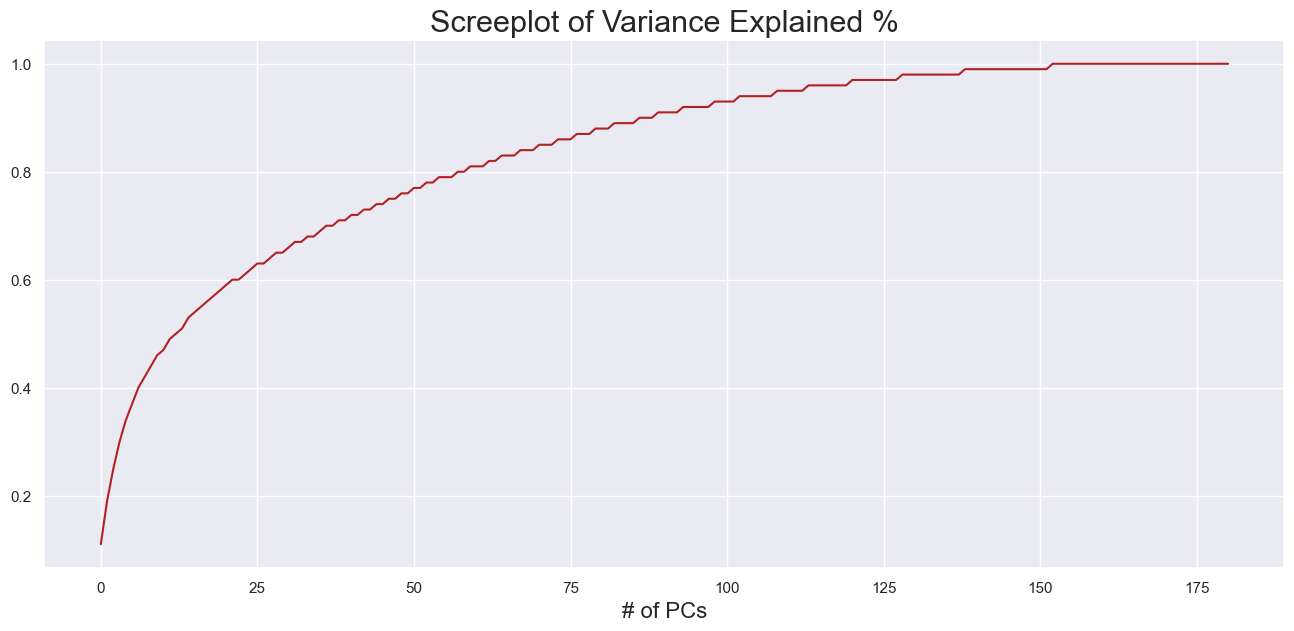

In [77]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum, color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)
plt.show()

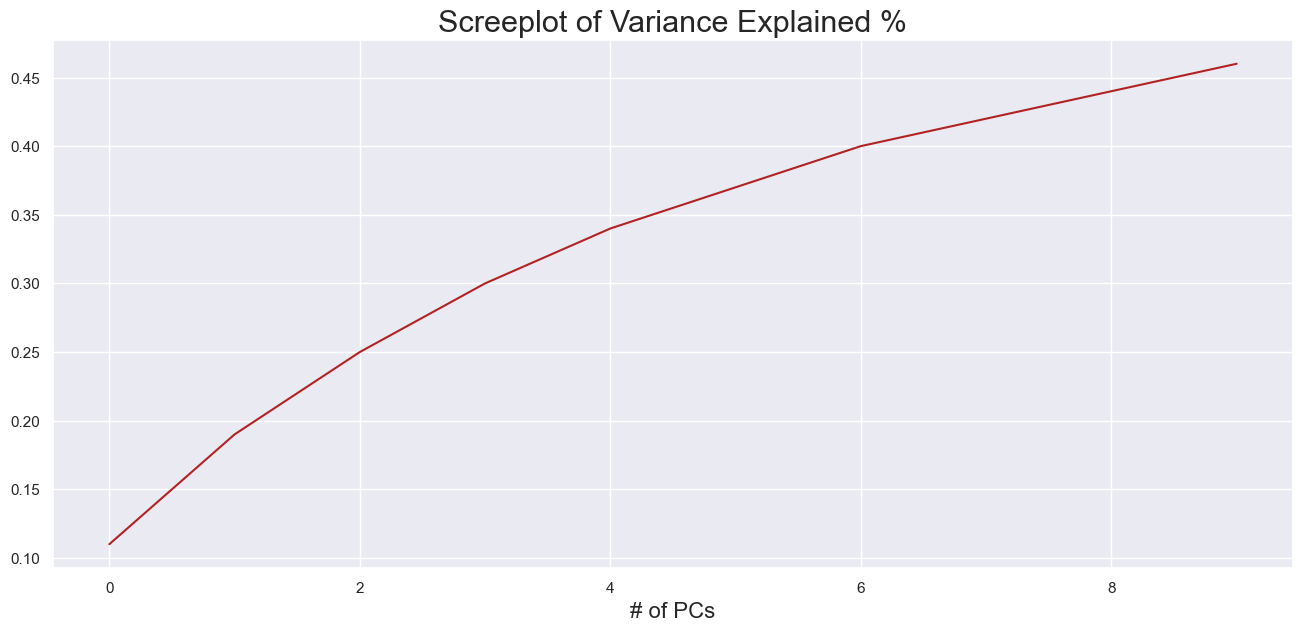

In [84]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum[:10], color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)
plt.show()

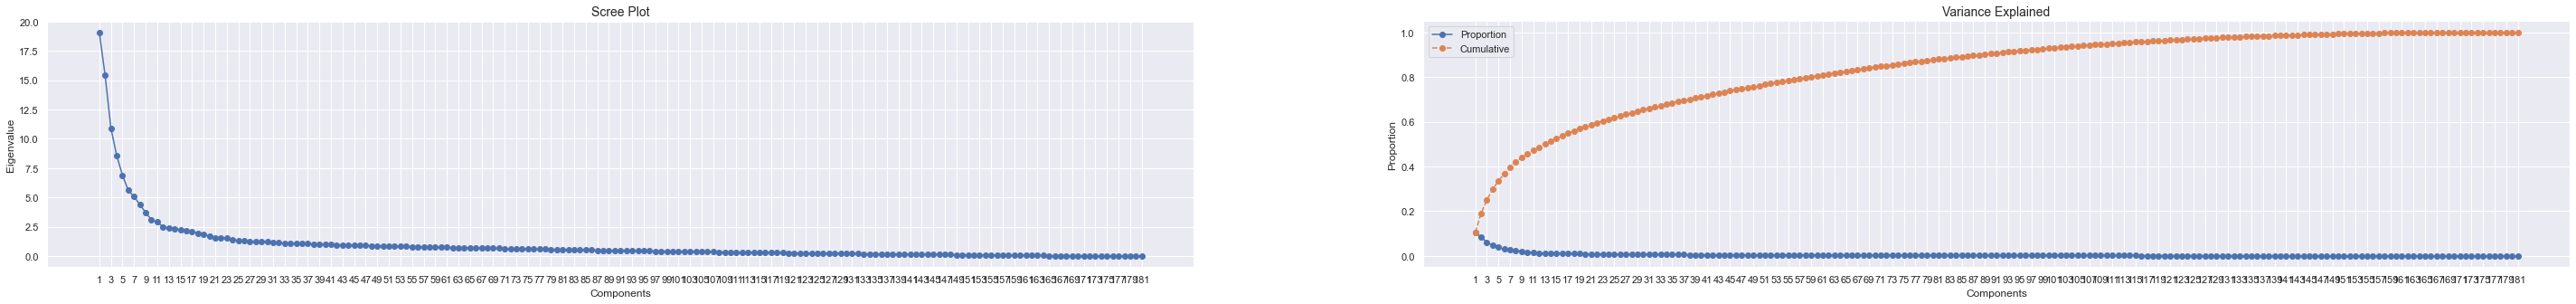

In [80]:
#figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

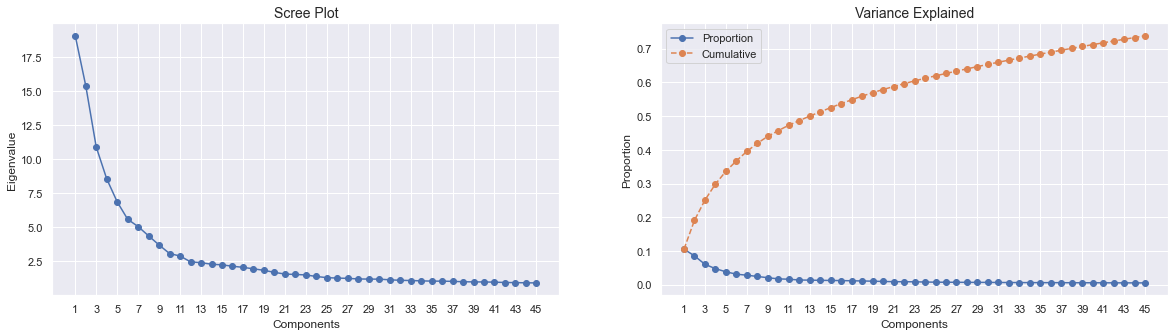

In [109]:
#figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# draw plots
ax1.plot(pca.explained_variance_[:45], marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_[:45], marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_[:45]), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, 45, 2))
ax1.set_xticklabels(range(1, 45 + 1, 2))
ax2.set_xticks(range(0, 45, 2))
ax2.set_xticklabels(range(1, 45 + 1, 2))

plt.show()

In [ ]:
#A minha resposta seria 6 PC's ---> se víssemos só os primeiros 10

In [ ]:
# A minha resposta seria 10/12 se víssemos os primeiros 45, já que segundo o Critério Pearson é o que mais nexo tem

In [110]:
pca = PCA(n_components=11)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.220459,-4.292591,0.303455,0.156412,-2.581398,1.037172,-1.437811,-0.641715,-0.903339,1.913826,2.221766
1,-11.397590,2.063092,-1.165910,5.819891,-2.387693,-5.195582,4.284847,-1.620998,0.171482,-1.528739,2.986260
2,4.458247,-4.908460,-0.708175,-0.090077,0.074052,-0.171730,0.350294,-3.145234,2.347722,1.311380,0.537710
3,3.589997,0.922961,-0.925851,2.731979,-0.100535,-4.307117,4.999270,-1.183939,-3.292426,-0.202657,2.418151
4,4.178653,0.087781,0.419047,-0.546764,-5.518853,-0.077745,0.676819,5.164203,4.052256,1.277367,-2.970128
...,...,...,...,...,...,...,...,...,...,...,...
95406,1.536555,-4.419839,0.677269,-0.642387,2.365266,-1.906182,0.824177,-0.203666,1.811204,2.401935,-1.147341
95407,-2.820576,3.167618,-3.442351,-0.095236,3.089945,1.491597,1.663207,3.622044,-0.637580,0.073189,-1.895212
95408,-7.785184,-1.543872,-2.493446,3.055001,2.099615,0.596178,2.167697,-0.076675,2.300718,-3.560569,1.143737
95409,1.913578,1.653148,-4.070029,0.273807,-2.375811,3.397972,0.258397,2.524931,-0.881665,-0.759384,-2.179330


In [112]:
#Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,ODATEDW,TCODE,STATE,Age,DOMAIN,HOMEOWNR,INCOME,GENDER,WEALTH1,HIT,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,2009-01,0,IL,0.083353,T2,,5.0,F,9.0,-0.358223,...,-4.292591,0.303455,0.156412,-2.581398,1.037172,-1.437811,-0.641715,-0.903339,1.913826,2.221766
1,2014-01,1,CA,-0.946773,S1,H,6.0,M,9.0,1.356052,...,2.063092,-1.165910,5.819891,-2.387693,-5.195582,4.284847,-1.620998,0.171482,-1.528739,2.986260
2,2010-01,1,NC,0.014678,R2,U,3.0,M,1.0,-0.143938,...,-4.908460,-0.708175,-0.090077,0.074052,-0.171730,0.350294,-3.145234,2.347722,1.311380,0.537710
3,2007-01,0,CA,0.701428,R2,U,1.0,F,4.0,-0.143938,...,0.922961,-0.925851,2.731979,-0.100535,-4.307117,4.999270,-1.183939,-3.292426,-0.202657,2.418151
4,2006-01,0,FL,1.250829,S2,H,3.0,F,2.0,6.070309,...,0.087781,0.419047,-0.546764,-5.518853,-0.077745,0.676819,5.164203,4.052256,1.277367,-2.970128


In [113]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

#Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

#If it has a high value in PC1, it has a high income - as the correlation is higher positive-correlated

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Age,0.041286,0.006637,0.159129,-0.108137,-0.063319,-0.005147,0.002014,0.049519,-0.047945,-0.005803,0.036244
HIT,-0.063236,0.012688,0.033834,-0.041072,-0.064988,0.055845,-0.035604,0.047753,-0.019975,0.003298,0.021060
MALEMILI,-0.007688,0.079753,-0.138662,-0.001607,0.250943,0.144575,0.070682,0.353475,0.009205,0.191437,-0.014898
MALEVET,-0.115990,-0.291158,0.297893,-0.285641,0.078708,-0.023868,-0.097097,0.378559,-0.056802,0.020730,-0.192241
VIETVETS,-0.140714,-0.075273,-0.444437,0.145491,0.191600,0.111219,0.069628,0.097707,0.035362,-0.009977,-0.104603
WWIIVETS,0.038992,-0.054518,0.528169,-0.307112,-0.200433,-0.137986,-0.038727,0.070595,-0.069890,-0.039756,0.007567
LOCALGOV,0.031013,-0.050332,0.005569,-0.030467,-0.155247,0.024473,0.172712,0.304759,-0.048826,-0.003095,-0.215747
STATEGOV,0.069476,-0.014181,-0.014110,-0.025989,-0.002280,0.308695,0.322306,0.186416,0.163022,-0.004995,-0.093225
FEDGOV,0.011384,0.036064,-0.145300,0.004785,0.170395,0.097361,0.124108,0.502414,0.021832,0.174118,-0.219288
POP901,0.015117,0.058733,-0.114026,-0.026781,0.096261,-0.075032,0.055542,-0.032662,0.082771,0.016783,0.120957


# Categorical Features

#### -> Pieplots

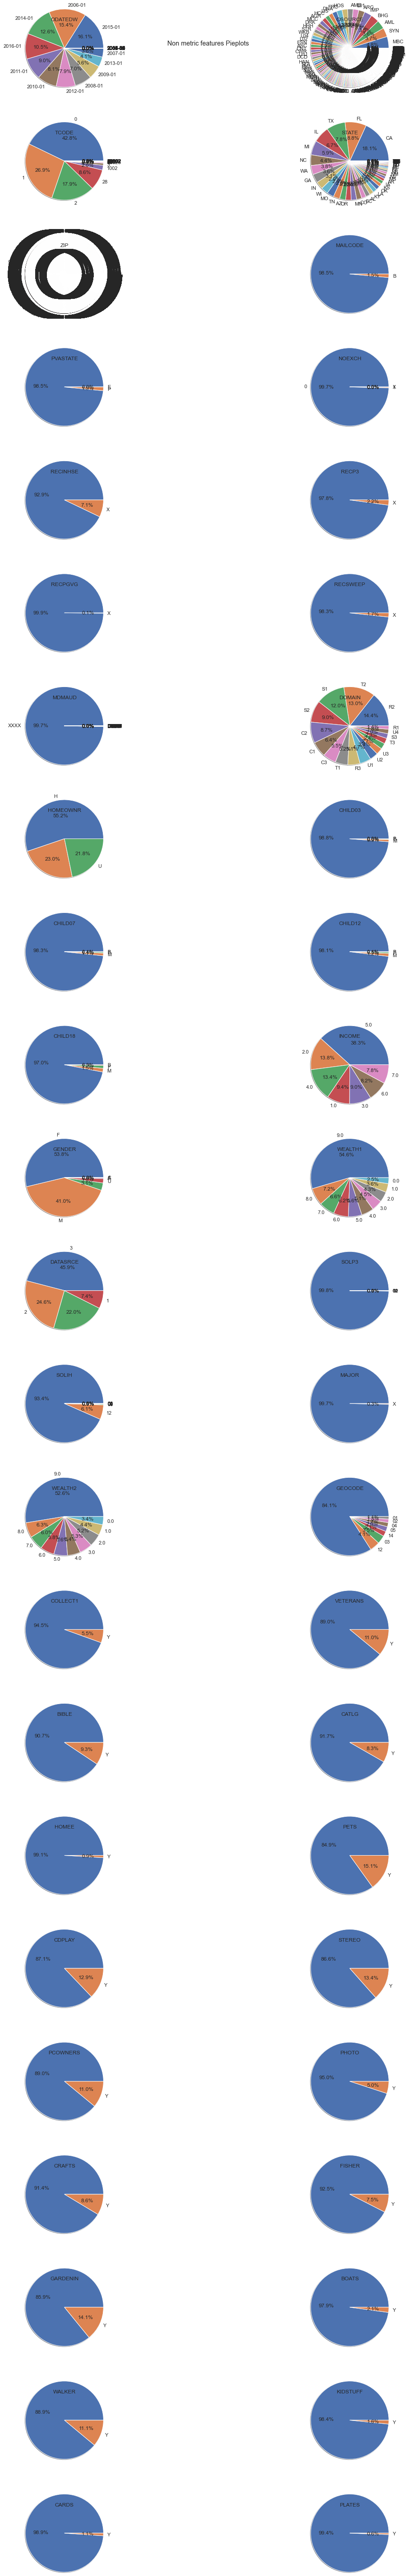

In [69]:
# import plotly.express as px
# from plotly.subplots import make_subplots

# # Prepare figure. Create figures where each pieplot will be placed
# # use 'domain' type for Pie subplot
# for feat in non_metric_features:
#     fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
#     fig=px.pie(df[feat], names=feat, title=feat)
#     fig.show()

sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(23, 2, figsize=(20, 80))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.pie(df[feat].value_counts().values,labels=df[feat].value_counts().index,autopct='%1.1f%%', shadow=True, radius=2)
    ax.set_title(feat)
fig.tight_layout()
# Layout
# Add a centered title to the figure:
title = " Non metric features Pieplots"
plt.suptitle(title)
plt.show()

#### -> Single Value Features

In [114]:
# get number of unique values for each column using numpy
counts = list(df.nunique())
names = list(df.nunique().index)

def create_dict(keys, values): 
    return dict(zip(keys, values + [None] * (len(keys) - len(values))))
columns = create_dict(names, counts)

# record columns to delete
to_del = dict((k, v) for k, v in columns.items() if v == 1) 
to_del

{}

#### -> Remove the variables that for one category have more than 90% of the observations:

In [115]:
to_drop=[]
for feature in non_metric_features:
    for proportion in df[feature].value_counts()/len(df):
        if proportion > 0.90:
            to_drop.append(feature)
            break

print('The non metric features that have more than 90% in one of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have more than 90% in one of their categories/unique values (to be dropped because of their redundancy) are the following:
 []


#### ->Drop the categorical features with high variability , in case none of its categories have more than 10%:

In [66]:
to_drop=[]
for feature in non_metric_features:
    aux =[]
    for proportion in df[feature].value_counts()/len(df):
        if proportion < 0.10:
            aux.append(proportion)
    if len(aux)==len(df[feature].value_counts()): # if all categories have less than 10%;
        to_drop.append(feature)

print('The non metric features that have less than 10% in all of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have less than 10% in all of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['OSOURCE', 'ZIP', 'MINRDATE', 'FISTDATE']


### Reduction Cardinality

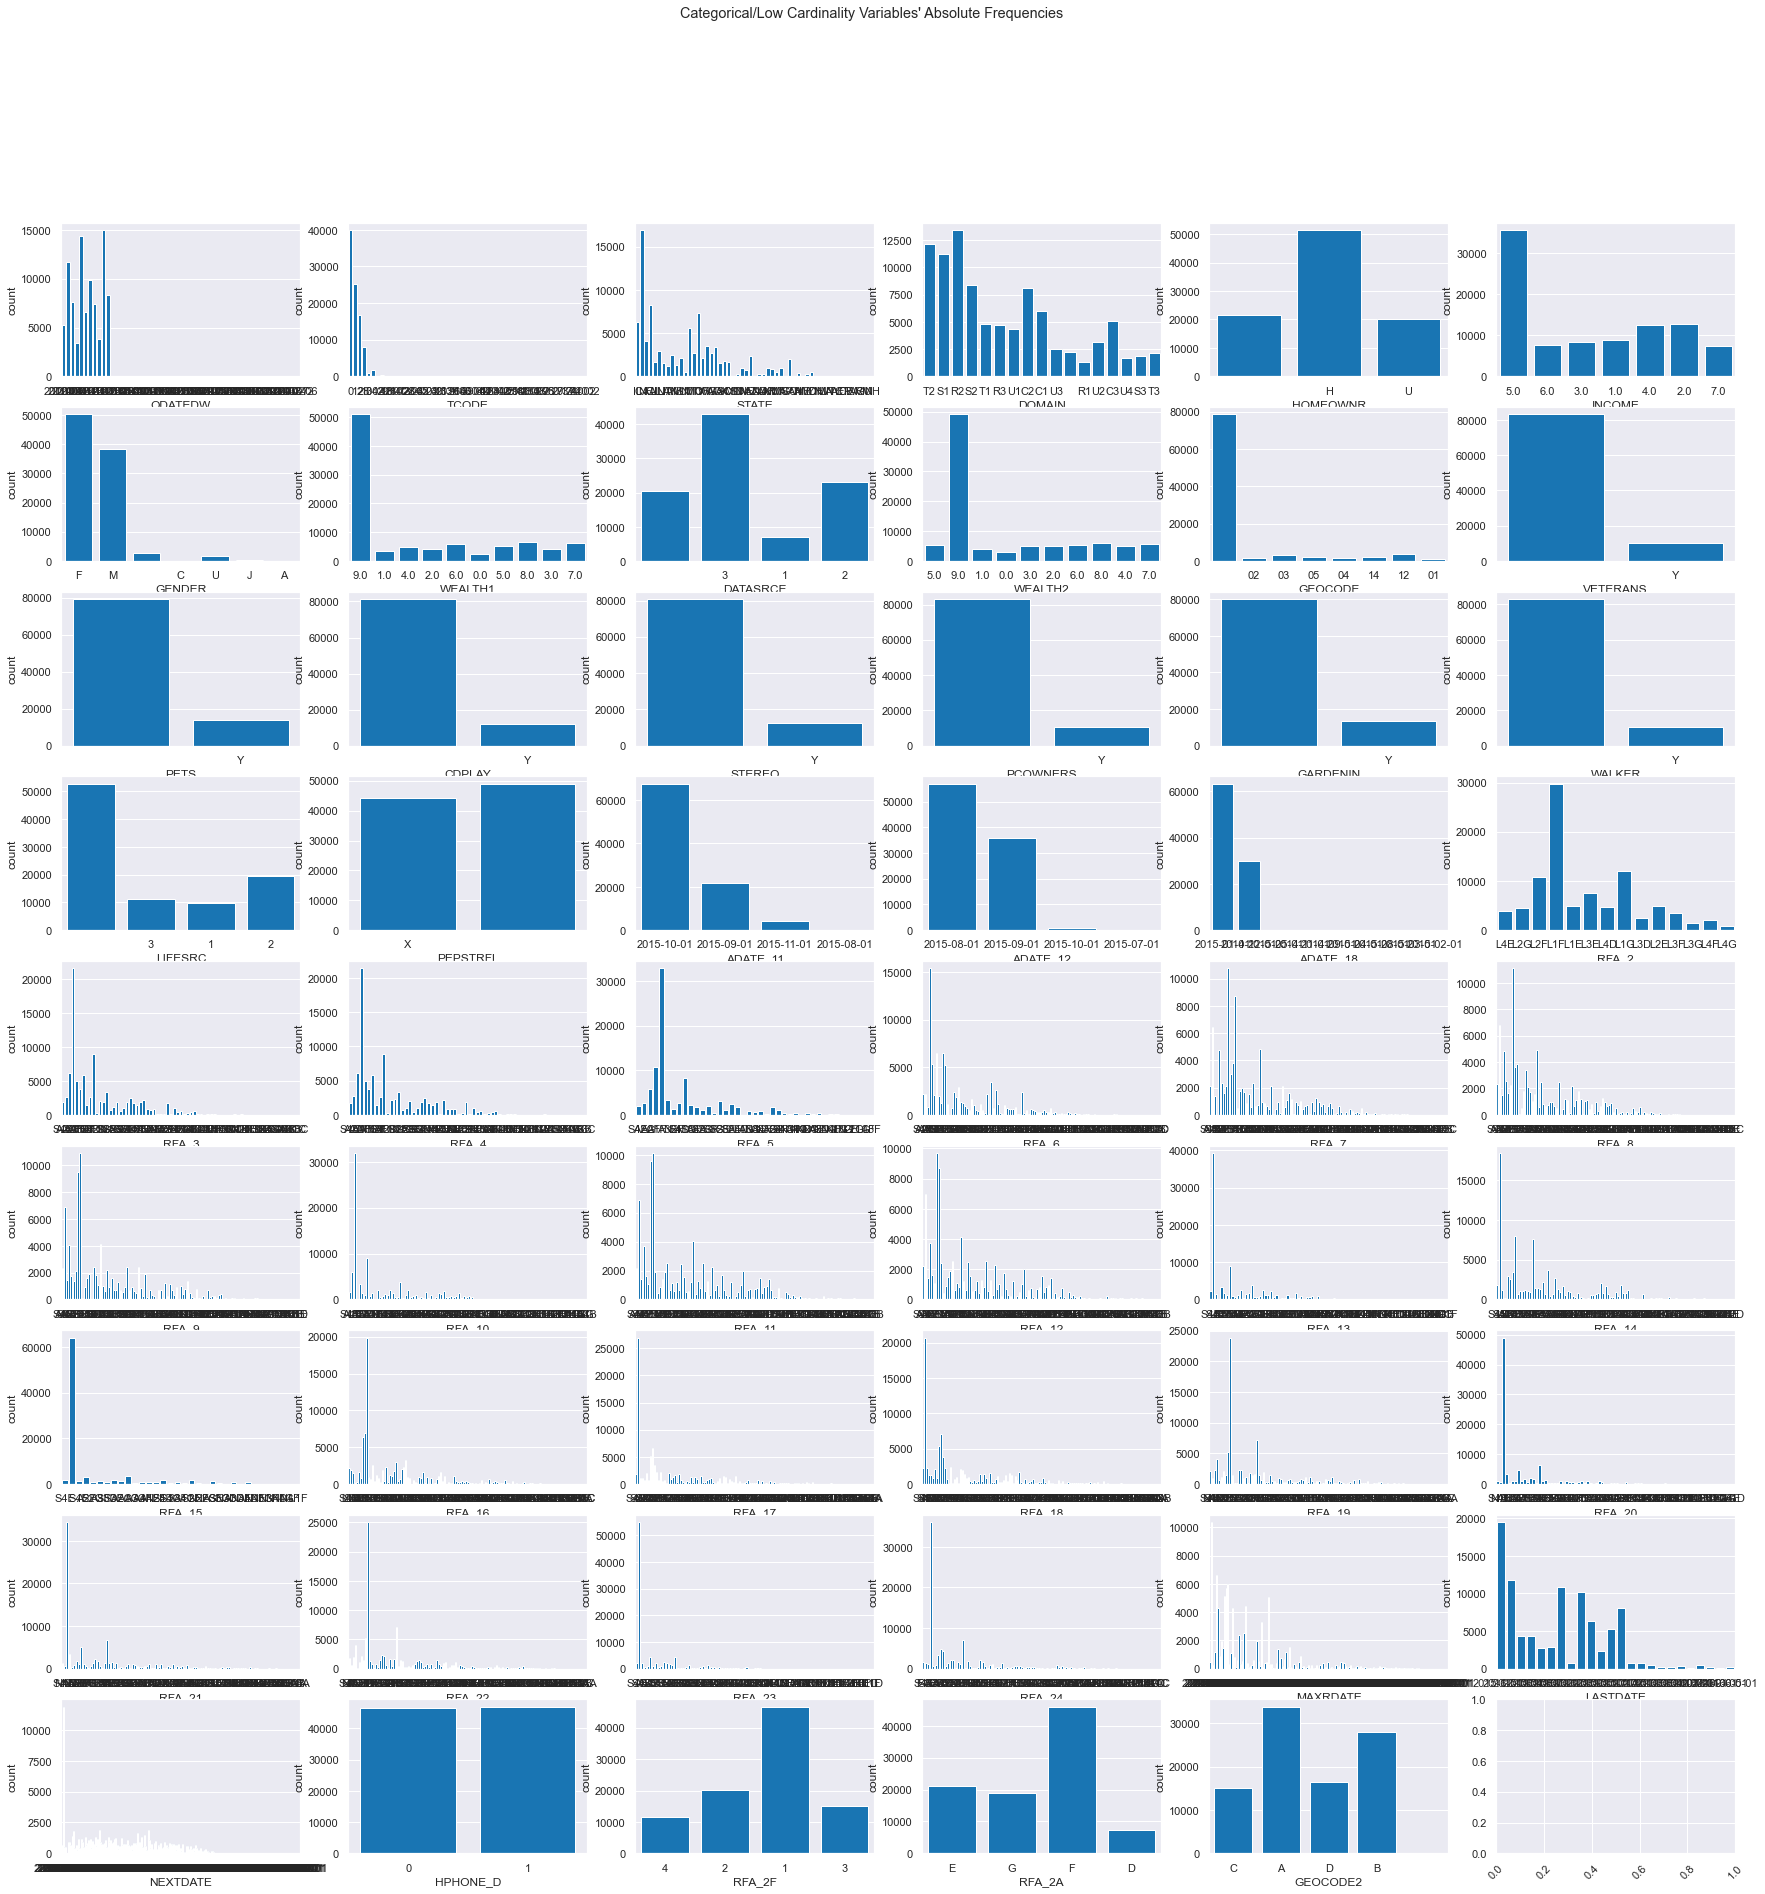

In [67]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(9, ceil(len(non_metric_features) / 10), figsize=(30, 30))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat], ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)
plt.xticks(rotation=45)
plt.show()

#We can check that in status there is a "Whaetever" observation, and if we have in account the meaning of the variable: Status - if it is married or divorced or single, we should remove this observation, as it doesn't make any sense in this situation.
#However, we can check also that in Description we have a observation called "Horrible". Contudo, in this case, as it is - as the name of the variable transmits - a description of something, we should take in account this observation, despite the fact it is rare, we shouldn't eliminate it.

In [124]:
import mca

In [127]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)

In [84]:
mca_ben = mca.MCA(df[non_metric_features])
mca_ind = mca.MCA(df[non_metric_features], benzecri=False)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [116]:
pip install prince

#You have more than 2 variables and they are all categorical: use multiple correspondence analysis (prince.MCA)

In [118]:
df_categorical = df[non_metric_features].copy()

In [126]:
mca.dummy(df_categorical, cols=None) #Tranforming first in dummy

ODATEDW                                                                  \
      2003-06 2004-01 2005-01 2006-01 2006-04 2006-08 2006-09 2006-11 2006-12   
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       1       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
95406       0       0       0       0       0       0       0       0       0   
95407       0       0       0       0       0       0       0       0       0   
95408       0       0       0       0       0       0       0       0       0   
95409       0       0       0       0       0       0       0       0       0   
95410       0       0       0       1       0       0       0       0       0   

               ... RFA_2F RFA_2A          GEOCODE2              
      2007-01  ...      4      D  E  F  G           A  B  C  D  
0           0  ...      1      0  1  0  0        0  0  0  1  0  
1           0  ...      0      0  0  0  1        0  1  0  0  0  
2           0  ...      1      0  1  0  0        0  0  0  1  0  
3           1  ...      1      0  1  0  0        0  0  0  1  0  
4           0  ...      0      0  0  1  0        0  1  0  0  0  
...       ...  ...    ...    ... .. .. ..      ... .. .. .. ..  
95406       0  ...      1      1  0  0  0        0  0  0  1  0  
95407       0  ...      0      0  0  0  1        0  0  0  1  0  
95408       0  ...      0      0  0  1  0        0  1  0  0  0  
95409       0  ...      0      0  1  0  0        0  0  1  0  0  
95410       0  ...      1      0  0  1  0        0  1  0  0  0  

[93363 rows x 2731 columns]

In [128]:
df_dummy = mca.dummy(df_categorical, cols=None) #Tranforming first in dummy

In [129]:
mca_ben = mca.MCA(df_dummy)
mca_ben

MemoryError: Unable to allocate 64.9 GiB for an array with shape (93363, 93363) and data type float64

In [130]:
mca_ind = mca.MCA(df_dummy, benzecri=False)
mca_ind

MemoryError: Unable to allocate 64.9 GiB for an array with shape (93363, 93363) and data type float64

In [123]:
import prince

mca = prince.MCA(n_components=10, n_iter=3, copy=True, check_input=True, engine='auto', random_state=42)
mca = mca.fit(df_categorical)
mca

MCA(n_components=10, n_iter=3, random_state=42)

In [120]:
df_categorical

,ODATEDW,TCODE,STATE,DOMAIN,HOMEOWNR,INCOME,GENDER,WEALTH1,DATASRCE,WEALTH2,...,RFA_22,RFA_23,RFA_24,MAXRDATE,LASTDATE,NEXTDATE,HPHONE_D,RFA_2F,RFA_2A,GEOCODE2
0,2009-01,0,IL,T2,,5.0,F,9.0,,5.0,...,S4E,S4E,S4E,2014-02-01,2015-12-01,2010-03-01,0,4,E,C
1,2014-01,1,CA,S1,H,6.0,M,9.0,3,9.0,...,N1E,,F1E,2015-12-01,2015-12-01,2015-04-01,0,2,G,A
2,2010-01,1,NC,R2,U,3.0,M,1.0,3,1.0,...,S4D,S4D,S3D,2012-07-01,2015-12-01,2011-01-01,1,4,E,C
3,2007-01,0,CA,R2,U,1.0,F,4.0,3,0.0,...,A1D,,,2014-11-01,2015-12-01,2007-11-01,1,4,E,C
4,2006-01,0,FL,S2,H,3.0,F,2.0,3,9.0,...,I4E,A3D,A3D,2016-01-01,2016-01-01,2000-05-01,1,2,F,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95406,2010-01,0,FL,S2,H,6.0,F,6.0,3,6.0,...,S3C,S3C,S3C,2011-03-01,2016-02-01,2010-06-01,0,4,D,C
95407,2016-01,1,AK,C2,,5.0,M,9.0,,9.0,...,,,,2016-02-01,2016-02-01,2015-04-01,0,1,G,C
95408,2016-01,1,TX,C1,H,7.0,M,9.0,3,9.0,...,,,,2016-03-01,2016-03-01,2015-04-01,1,1,F,A
95409,2015-01,1,MI,C3,,5.0,M,9.0,,9.0,...,P1D,,,2015-01-01,2016-10-01,2015-01-01,1,3,E,B


In [138]:
lista = []
for non_name in non_metric_features:
    if df_categorical[non_name].value_counts().count()>4:
        lista.append(non_name)

for i in lista:
    print("---------------------------------------------------")
    print(df_categorical[i].value_counts())

---------------------------------------------------
2015-01    15000
2006-01    14338
2014-01    11757
2016-01     9834
2011-01     8376
2010-01     7564
2012-01     7399
2008-01     6556
2009-01     5248
2013-01     3832
2007-01     3382
2017-01       15
2015-09        4
2014-10        3
2012-09        3
2012-12        3
2015-10        3
2013-10        2
2013-09        2
2005-01        2
2009-12        2
2010-09        2
2015-06        2
2012-02        2
2009-10        2
2013-02        2
2004-01        1
2013-03        1
2006-09        1
2009-09        1
2008-10        1
2013-12        1
2003-06        1
2008-04        1
2006-08        1
2015-11        1
2007-04        1
2012-05        1
2006-11        1
2007-11        1
2015-12        1
2011-11        1
2007-02        1
2011-09        1
2007-07        1
2011-03        1
2010-11        1
2010-12        1
2011-02        1
2006-04        1
2010-03        1
2014-02        1
2010-10        1
2006-12        1
Name: ODATEDW, dtype: int64
--

       20741
A1E     7061
A1F     5424
A1D     3857
A1G     2363
       ...  
P1B        1
S2A        1
N3B        1
A4A        1
S3A        1
Name: RFA_18, Length: 122, dtype: int64
---------------------------------------------------
       23878
A1E     7133
A1F     5264
A1D     4073
S2E     2283
       ...  
A4B        3
P1B        2
S4A        2
A4A        1
L4C        1
Name: RFA_19, Length: 108, dtype: int64
---------------------------------------------------
       49060
A1E     6297
A1F     4870
A1D     3274
A1G     2142
       ...  
I1G        2
U1E        2
L3F        1
U1D        1
L4E        1
Name: RFA_20, Length: 80, dtype: int64
---------------------------------------------------
       34376
A1E     6613
A1F     5046
A1D     3536
A1G     2192
       ...  
S3A        2
P1B        2
S4A        2
A4B        2
A4A        1
Name: RFA_21, Length: 102, dtype: int64
---------------------------------------------------
       25033
A1E     7113
A1F     5236
A1D     4028
A1G     2

In [92]:
# faço um a um????

df_categorical["ODATEDW"].value_counts()
df_categorical["ODATEDW"] ----------------------------> reduzir para anos?

0        2009-01
1        2014-01
2        2010-01
3        2007-01
4        2006-01
          ...   
95406    2010-01
95407    2016-01
95408    2016-01
95409    2015-01
95410    2006-01
Name: ODATEDW, Length: 93363, dtype: object

In [133]:
df_categorical["GENDER"].value_counts().index

Index(['F', 'M', ' ', 'U', 'J', 'C', 'A'], dtype='object')

In [137]:
df_categorical["GENDER"] = df_categorical["GENDER"].apply(lambda x: "F" if (x == "F") else ("M" if (x == "M") else ("Unknown")))
df_categorical["GENDER"].value_counts().index

Index(['F', 'M', 'Unknown'], dtype='object')

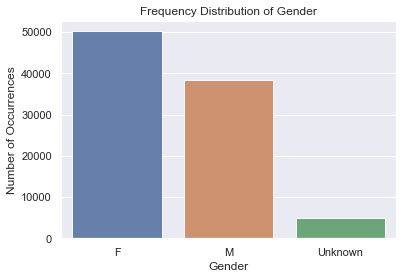

In [140]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#carrier_count = df[non_metric_features]["GENDER"].value_counts()
sns.set(style="darkgrid")
sns.barplot(x = df_categorical["GENDER"].value_counts().index, y = df_categorical["GENDER"].value_counts().values, alpha=0.9)
plt.title('Frequency Distribution of Gender')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [ ]:
df_categorical["GEOCODE2"].value_counts().index
df_categorical["GENDER"] = df_categorical["GENDER"].apply(lambda x: "F" if (x == "F") else ("M" if (x == "M") else ("Unknown")))
df_categorical["GENDER"].value_counts().index

In [ ]:
import mca
mca_df = mca.MCA(df[:, non_metric_features])